In [24]:
import allel
import msprime
import tskit
#from math import exp,log
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import multiprocessing as mp
import time
import nlopt

In [6]:
import multiprocessing as mp
import time
import nlopt

In [7]:
import math

## Working out how to count pairwise comparisons from sim data efficiently

This outlines the current approach of using a rolling window generator, which are implemented in the next section

In [10]:
testSeq = np.array([1,0,1,0,0,1,1,0]) # start with a sequence of positions: 0 if homozygous site, 1 if heterozygous


#make a matrix comparing the first site ("1") to the rest of the sequence (the adjacent nucleotides)
# each column represents a site, increasingly far from the first site
# for a column, the pairwise het type is recorded with a "1" in the corresponding row:
    # idx 0 -> h0, idx 1 -> h1, idx 2 -> h2
    # each column sums to one
firstToRestComparision = np.zeros((3,len(testSeq)-1),dtype=int)

#if the first site is homozygous (0), then comparison site of (0) produces h0, while (1) produces h1
#so they are recorded in the 0th and 1st row indices

#if the first site is heterozygous (1), then comparison site with (0) produces h1, while (1) produces h2
#so they are recorded in the 1st and 2nd row indicies

if testSeq[0]==0:
    for idx,val in enumerate(testSeq[1:]):
        firstToRestComparision[val][idx]=1
if testSeq[0]==1:
    for idx,val in enumerate(testSeq[1:]):
        firstToRestComparision[val+1][idx]=1
        
print(firstToRestComparision)

[[0 0 0 0 0 0 0]
 [1 0 1 1 0 0 1]
 [0 1 0 0 1 1 0]]


In [11]:
#to get the comparison of the second-site to the rest

# remove the first comparison. It's already been made.
secondToRestComparison = firstToRestComparision[:,1:]
print(secondToRestComparison)

# if the next site is the same state (also het in our case), then the comparisons of the 
# second site to the rest of the sites (that is, to the right) will give the same result 

# However, as in our testSeq example, the first site may be a het (1) while the second is hom (0).
# the het type changes relative to the first: h1->h0 and h2->h1, because only one of the two sites is now heterozygous
# we can make this easy by re-shuffling the rows 
print()
secondToRestComparison = secondToRestComparison[[2,0,1],:]
print(secondToRestComparison)

[[0 0 0 0 0 0]
 [0 1 1 0 0 1]
 [1 0 0 1 1 0]]

[[1 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 1 1 0 0 1]]


## Generator for pair-wise comparisons and helper functions

__rolling_windows()__ is a generator for the sequence of pair-wise het states site-by-site along the chromosome for a given maximum distance at which we compare sites. It takes the sequence of single-locus het states for the chromosome (genotype) and the sequence of two-locus het states comparing the first site to all the rest. 

__get_het_states()__ takes a ts with mutations as input and returns the full genotype (het or hom state) along the chromosome 

__get_compare_seq()__ takes the sequence of single-locus het states and returns the sequence of two-locus het states comparing the first site to the rest (all sites to the right).

In [45]:
#####
# this function takes as input 
#   1. the sequence of hom/het states along the genome
#   2. the sequence of comparisons of first site to the rest, formatted as a 3xL matrix as described above
#   3. the maximum distance (window_size) we will include in our final data set.

#  is returns a generator that produces, for each site,  the (3 x window_size) matrix counting pairwise het states
#  for comparisons with the window_size bases to the right
#  we can simply sum over the generator to get the counts of each het state for each distance across all comparisons made. 

def rolling_window(siteSeq,compareSeq,window_size):  
    # siteSeq is the binary array of all sites from simulation, 0 and 1 indicating homozygous and heterozygous
    
    # compareSeq is the matrix for comparison of first site with all the rest. Each column is an increasingly distant site
    # and for each column, the rows correspond to h0, h1, and h2 types, with 1 indicating the state of each comparison
    
    # this generator returns the 3xwindow_size matrix sub-set of the compare sequence corresponding to sliding one basepair along the genome
    # adjusting the compareSeq entries when the first site in the comparison chcanges state
    
    length = len(compareSeq[0])
    i=0
    firstState = siteSeq[0]
    while i+window_size <= length:
        thisState = siteSeq[i]
        thisCompare = compareSeq[:,i:i+window_size]
        if thisState == firstState:
            yield (thisCompare)
        elif firstState == 0:
            adjustCompare = thisCompare[[2,0,1],:]
            yield (adjustCompare)
        elif firstState == 1:
            adjustCompare = thisCompare[[1,2,0],:]
            yield (adjustCompare)
        i+=1

In [13]:
g = rolling_window(testSeq,firstToRestComparision,4)
for x in g:
    print(x)

[[0 0 0 0]
 [1 0 1 1]
 [0 1 0 0]]
[[0 1 1 0]
 [1 0 0 1]
 [0 0 0 0]]
[[0 0 0 0]
 [1 1 0 0]
 [0 0 1 1]]
[[1 0 0 1]
 [0 1 1 0]
 [0 0 0 0]]


In [14]:
g = rolling_window(testSeq,firstToRestComparision,4)
countsByDistance = sum(g)

In [15]:
def get_compare_seq(hetStateArr):
    #takes list of all sites and singlel-site het states and returns a matrix of two-site het states 
    #for comparison of the first site to all the rest
    firstToRestComparision = np.zeros((3,len(hetStateArr)-1),dtype=int)
    
    if hetStateArr[0]==0:
        for idx,val in enumerate(hetStateArr[1:]):
            firstToRestComparision[val][idx]=1
    if hetStateArr[0]==1:
        for idx,val in enumerate(hetStateArr[1:]):
            firstToRestComparision[val+1][idx]=1        
    return firstToRestComparision

def get_het_states(mutTreeSeq):
    hetStates = np.zeros(int(mutTreeSeq.sequence_length),dtype=int)
    for x in mutTreeSeq.variants():
        hetStates[int(x.position)] = 1
    return hetStates

In [16]:
len(get_compare_seq(np.array([1,0,1,0,0,1,1,0]))[0])

7

## Functions from heRho needed for single-chromosome estimation 

__note__ these functions allow for single-distance estimates or composite estimate over distances for __cross-over only model__

In [17]:
def two_locus_het_probs(th,rho,d):
    r = rho*d
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    return([calcH0,calcH1,calcH2])

In [18]:
def find_max_like_single_dist(args):
    testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0000000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.01]
    #startPoint = [0.01]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return([testChr[0],res[0]])

In [52]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*math.log(calcH0) + h1*math.log(calcH1)+h2*math.log(calcH2)
    return(val)

In [53]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - math.exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*math.log(calcH0) + h1*math.log(calcH1)+h2*math.log(calcH2)
    return(val)

In [21]:
def get_rho(d,rbp,g,L):
    r = rbp*(d+2*(g/rbp)*L*(1 - math.exp(-d/L)))
    return r

In [22]:
def HeRho_estimate_one_chromosome(cArr):  
    test = cArr
    lowerBounds = [ 0.0000001, 0.0000001,10]
    upperBounds = [ 0.5, 0.5, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,test))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [23]:
def combine_rep_results(repArr): #repArr is array of replicate hero input tables, here combining them
    repDFList = [pd.DataFrame(x,columns=["d","h0","h1","h2","H"]) for x in repArr]
    repDF = pd.concat(repDFList)
    numSamples = len(repArr)
    repDF = repDF.groupby(['d'],as_index=False).sum()
    repDF['H'] = repDF['H']/numSamples
    return(repDF.to_numpy())

## msprime sims description
## Calculating two-locus het state probabilites by distance. 

__crossover-only. Models: boring coalescent, instantaneous bottleneck__

Here we run a chromosome-length msprime simulation corresponding to params from the mouse estimates. We look at the boring coalescent, an instantaneous bottleneck model, and a boring coalescent simulation with genetic diversity decreased to match that expected under the bottleneck model. 


theta = 0.0071
rho = 0.0017
mu = 5.4e-9
Ne = theta/(4*mu)
r = rho/(4*Ne)
L=63e6
maxDistance = 2000
gamma = 0.0035
L=108

corresponds to 
Ne = 328703.7037037037 and 
r = 1.2929577464788732e-09

In [390]:
scaled_rho_expected= [[d,get_rho(d, 0.0017,0.0035,108)/0.0071/d] for d in range(1,2000)]

[[1, 1.220801744274461], [2, 1.216279356506843], [3, 1.211784755870453], [4, 1.2073177502897037], [5, 1.202878149105241], [6, 1.1984657630630362], [7, 1.194080404303611], [8, 1.1897218863513326], [9, 1.1853900241037807], [10, 1.1810846338212238], [11, 1.1768055331161524], [12, 1.172552540942916], [13, 1.1683254775874294], [14, 1.1641241646569627], [15, 1.159948425070017], [16, 1.1557980830462709], [17, 1.151672964096618], [18, 1.1475728950132682], [19, 1.1434977038599436], [20, 1.1394472199621355], [21, 1.1354212738974514], [22, 1.1314196974860313], [23, 1.1274423237810385], [24, 1.1234889870592317], [25, 1.119559522811604], [26, 1.115653767734099], [27, 1.1117715597184032], [28, 1.1079127378428033], [29, 1.1040771423631224], [30, 1.100264614703725], [31, 1.0964749974485895], [32, 1.0927081343324594], [33, 1.0889638702320539], [34, 1.0852420511573537], [35, 1.0815425242429568], [36, 1.0778651377394963], [37, 1.0742097410051303], [38, 1.070576184497096], [39, 1.0669643197633338], [40, 1

## Basic Coalescent,

returning for each replicate, the distance  matrix for herho input
which can be combined using "combine_rep_results()" to run optimization on. 

In [57]:
def sim_basic_model(itt):

    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 2000


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        model=[msprime.StandardCoalescent()],
        ploidy=2,
        population_size=Ne,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )
    
    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

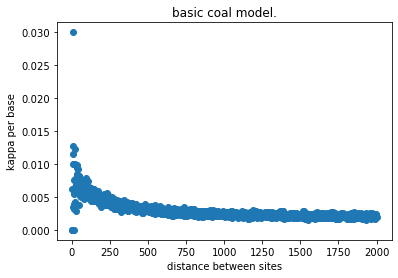

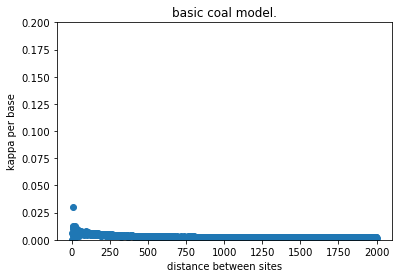

[0.001688367689032053, 0.003192859437247071, 107.77714949595267]


In [58]:
test_basic = sim_basic_model(0)
test_basic = np.array(test_basic)

res_basic = [find_max_like_single_dist(x) for x in test_basic[:]]
x,y = zip(*res_basic)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

plt.ylim(0,0.2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(HeRho_estimate_one_chromosome(test_basic))

In [59]:
print(test_basic.tolist())

[[1.0, 49303268.0, 689782.0, 4950.0, 0.00699709988399536], [2.0, 49303203.0, 689912.0, 4885.0, 0.00699709988399536], [3.0, 49303150.0, 690018.0, 4832.0, 0.006997099883995359], [4.0, 49303002.0, 690314.0, 4684.0, 0.006997099883995359], [5.0, 49303102.0, 690114.0, 4784.0, 0.00699709988399536], [6.0, 49303147.0, 690024.0, 4829.0, 0.00699709988399536], [7.0, 49303058.0, 690202.0, 4740.0, 0.00699709988399536], [8.0, 49303192.0, 689934.0, 4874.0, 0.006997099883995359], [9.0, 49303009.0, 690300.0, 4691.0, 0.00699709988399536], [10.0, 49303092.0, 690134.0, 4774.0, 0.00699709988399536], [11.0, 49303159.0, 690000.0, 4841.0, 0.006997099883995359], [12.0, 49303080.0, 690158.0, 4762.0, 0.00699709988399536], [13.0, 49303114.0, 690090.0, 4796.0, 0.00699709988399536], [14.0, 49303022.0, 690274.0, 4704.0, 0.006997099883995359], [15.0, 49303088.0, 690142.0, 4770.0, 0.00699709988399536], [16.0, 49302949.0, 690420.0, 4631.0, 0.00699709988399536], [17.0, 49302885.0, 690548.0, 4567.0, 0.00699709988399536], 

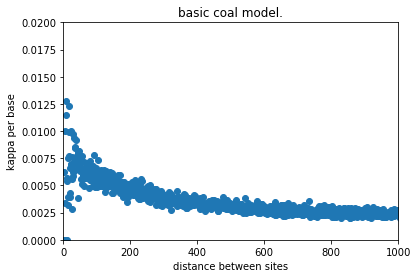

[0.001688367689032053, 0.003192859437247071, 107.77714949595267]


In [60]:
plt.xlim(0,1000)
plt.ylim(0,0.02)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(HeRho_estimate_one_chromosome(test_basic))

In [59]:
print(HeRho_estimate_one_chromosome(test_basic[100:]))
print(HeRho_estimate_one_chromosome(test_basic[200:]))
print(HeRho_estimate_one_chromosome(test_basic[500:]))

[0.0018555918873570253, 0.004111162052381335, 92.89500766234492]
[0.0018566801120129823, 0.004303319952471758, 88.57072466162]
[0.001863668008992206, 0.008391529305002464, 44.91126789497535]


In [394]:

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.004334116909715  /  0.007121494859794392  )/(0.0035/0.0071))

ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.2345814894531608


In [ ]:
print("true rho/theta = 0.239437")
print("true gamma/theta = 0.492957")

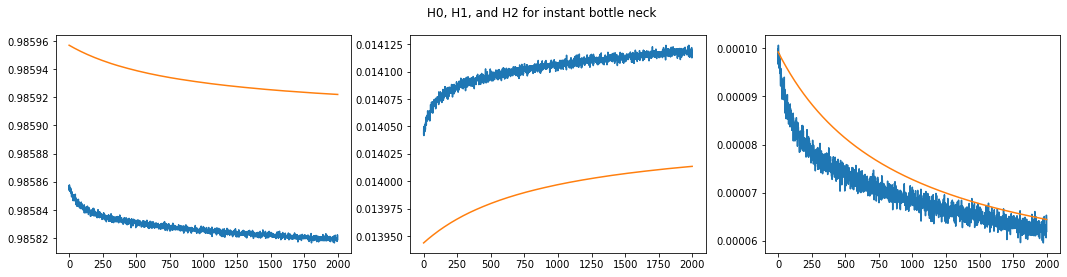

In [308]:
observed_hProbs_basic = np.apply_along_axis(lambda x: x/sum(x),1,test_basic[:,[1,2,3]])
expected_hProbs_basic = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_basic])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_basic[:,x])
    axs[x].plot(expected_hProbs_basic[:,x])
plt.show()

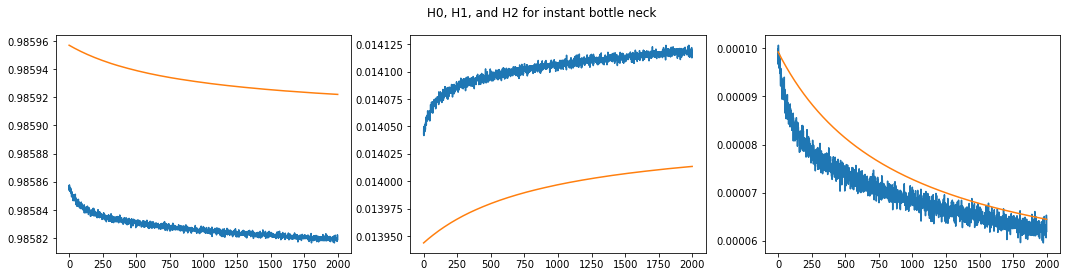

In [326]:
observed_hProbs_basic = np.apply_along_axis(lambda x: x/sum(x),1,test_basic[:,[1,2,3]])
expected_hProbs_basic = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_basic])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_basic[:,x])
    axs[x].plot(expected_hProbs_basic[:,x])
plt.show()

## Instantaneous bottleneck

Also have a function that runs the basic coalescent with a lower theta for comparison

returning for each replicate, the distance  matrix for herho input
which can be combined using "combine_rep_results()" to run optimization on.

##### sim_instant_bottleneck defined

In [51]:
def sim_instant_bottleneck(args): #in coal units
    itt, tBottle, tStrength = args
   
    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 2000

    Tb = tBottle*2*Ne #gens pastward to bottleneck in 2Ne gens
    Ts = tStrength*2*Ne #duration of bottleneck in 2Ne gens

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne)
    demography.add_instantaneous_bottleneck(time=Tb, strength=Ts, population=0)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)

    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### res instant bottleneck

In [ ]:
test_instant_bottle = sim_instant_bottleneck([0,0.5,2.0])
test_instant_bottle = np.array(test_instant_bottle)


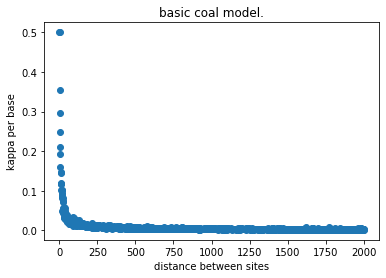

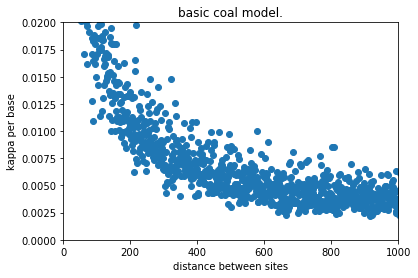

[0.0016571354539961342, 0.09071344675970033, 10.0]


In [52]:

res_instant_bottle = [find_max_like_single_dist(x) for x in test_instant_bottle[:]]
x,y = zip(*res_instant_bottle)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

plt.xlim(0,1000)
plt.ylim(0,0.02)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(HeRho_estimate_one_chromosome(test_instant_bottle))

In [62]:
print(test_instant_bottle.tolist())

[[1.0, 49694823.0, 302492.0, 685.0, 0.0030387415496619867], [2.0, 49694844.0, 302450.0, 706.0, 0.0030387415496619867], [3.0, 49694866.0, 302406.0, 728.0, 0.0030387415496619867], [4.0, 49694853.0, 302432.0, 715.0, 0.0030387415496619867], [5.0, 49694848.0, 302442.0, 710.0, 0.0030387415496619867], [6.0, 49694856.0, 302426.0, 718.0, 0.0030387415496619863], [7.0, 49694859.0, 302420.0, 721.0, 0.0030387415496619867], [8.0, 49694811.0, 302516.0, 673.0, 0.0030387415496619863], [9.0, 49694843.0, 302452.0, 705.0, 0.0030387415496619863], [10.0, 49694854.0, 302430.0, 716.0, 0.0030387415496619863], [11.0, 49694842.0, 302454.0, 704.0, 0.0030387415496619867], [12.0, 49694832.0, 302474.0, 694.0, 0.0030387415496619867], [13.0, 49694796.0, 302546.0, 658.0, 0.0030387415496619863], [14.0, 49694831.0, 302476.0, 693.0, 0.0030387415496619867], [15.0, 49694822.0, 302494.0, 684.0, 0.0030387415496619863], [16.0, 49694836.0, 302466.0, 698.0, 0.0030387415496619867], [17.0, 49694807.0, 302524.0, 669.0, 0.0030387415

In [60]:
print(HeRho_estimate_one_chromosome(test_instant_bottle[100:]))
print(HeRho_estimate_one_chromosome(test_instant_bottle[200:]))
print(HeRho_estimate_one_chromosome(test_instant_bottle[500:]))

[0.0015376809985909786, 0.022420299047378467, 43.35416991461395]
[0.0015184943263403165, 0.01736182819619391, 56.64636575083786]
[0.0015183422568931628, 0.008173451453866745, 120.44042708308226]


In [396]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      (  0.0016571354539961342  /  0.0030387415496619863  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.09071344675970033  /  0.0030387415496619863  )/(0.0035/0.0071))



ratio of (rho/theta)_observed / (rho/tehta)_expected:   2.277580166403638
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   60.55753780851577


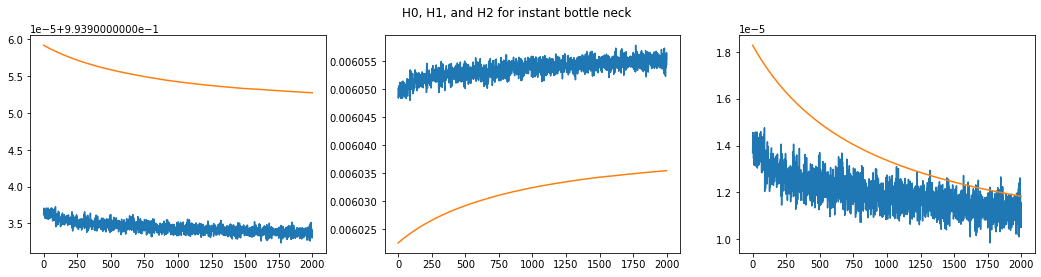

In [324]:
observed_hProbs_instant_bottle = np.apply_along_axis(lambda x: x/sum(x),1,test_instant_bottle[:,[1,2,3]])
expected_hProbs_instant_bottle = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_instant_bottle])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_instant_bottle[:,x])
    axs[x].plot(expected_hProbs_instant_bottle[:,x])
plt.show()

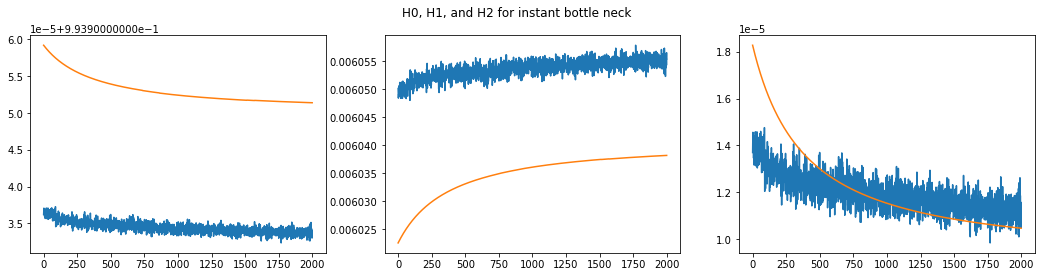

In [323]:
observed_hProbs_instant_bottle = np.apply_along_axis(lambda x: x/sum(x),1,test_instant_bottle[:,[1,2,3]])
expected_hProbs_instant_bottle = np.array([two_locus_het_probs(x[-1],0.0017*(0.0071/x[-1]),x[0]) for x in test_instant_bottle])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_instant_bottle[:,x])
    axs[x].plot(expected_hProbs_instant_bottle[:,x])
plt.show()

##### Probability of coal before, during, or after instant bottleneck and expected diversity 

In [ ]:
Tb = 0.5*2*Ne #gens pastward to bottleneck
Ts = 1.0*2*Ne #duration of bottleneck in gens

#probability of coalesence before, during, or after the bottleneck
#need to convert to coal units again for calculations, so use lowercase here. 
tb = Tb/(2*Ne) #time to bottleneck pastward in coal units
ts = Ts/(2*Ne) #duration of bottleneck in coal units
l = 1 #rate of coal in units of 2Ne

prBefore = (1 - math.exp(-l*tb))
prDuring = math.exp(-l*tb)*( 1 - math.exp(-l*ts))
prAfter = 1 - prBefore-prDuring #can also derive directly 

#expected time to coal, given coal before, during or after bottleneck

tCoalBefore = (1 - math.exp(tb*l)+tb*l)/(l*(1 - math.exp(tb*l))) #condition, normalize, recalculate mean
tCoalDuring = tb #msprime assumes no time occurs during bottleneck, so all occurs at tb. 
tCoalAfter = tb+1/l #time to beginning of bottleneck plus expected time to neutral coal 

meanTimeNeutral = 1/l
meanTimeBottleneck = prBefore*tCoalBefore+prDuring*tCoalDuring+prAfter*tCoalAfter

print(prBefore,prDuring,prAfter)
print(tCoalBefore,tCoalDuring,tCoalAfter)
print(meanTimeNeutral*0.0071,0.0071*meanTimeBottleneck)

## Bottleneck - NOT instantaneous

modeling a population bottleneck as a size change for a duration of time. current and ancestral pop sizes are Na.  Bottleneck pop size is Nb < Na. 

This effectively allows some mutation to occur during the bottle neck...

##### non-instant bottleneck simulation function def

In [75]:
def sim_bottleneck(args):
    itt, tBottle, tDuration,NBottleFrac = args
    
    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    ##currently chosen to match probabilites to the instantaneous bottleneck model
    ## is there an effect of Ne change indepenednet of the duration? expectation has only compound params...
    #tBottle = 0.5
    #tDuration = 1.0/10
    Nbottle = NBottleFrac*Ne
    

    Tb = tBottle*2*Ne #gens pastward to bottleneck in 2Ne gens
    Td = tDuration*2*Ne #duration of bottleneck in 2Ne gens

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne)
    demography.add_population_parameters_change(time=Tb,initial_size=Nbottle)
    demography.add_population_parameters_change(time=Tb+Td,initial_size=Ne)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### short strong bottleneck
Tbottle= 0.5
duration of bottleneck = 0.1
pop size bottleneck = 0.1 * Ne


For duration Nb = 1/10 Na, Tduration = 1/10. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above.


In [76]:
test_bottle_strong_short = sim_bottleneck([0,0.5,1.0/10,1/10])
test_bottle_strong_short = np.array(test_bottle_strong_short)

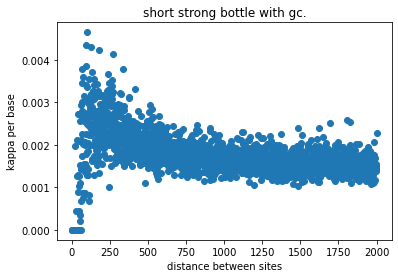

[0.0012856957654356742, 0.0007813256052147208, 254.50737672671465]


In [77]:
res_bottle_strong_short = [find_max_like_single_dist(x) for x in test_bottle_strong_short[:]]
x,y = zip(*res_bottle_strong_short)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("short strong bottle with gc.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_strong_short))

In [397]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0012856957654356742 / 0.00463072522900916   )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.0007813256052147208  /  0.00463072522900916  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.1595744260796292
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   0.34227355776170737


In [78]:
print(test_bottle_strong_short.tolist())

[[1.0, 49537201.0, 458550.0, 2249.0, 0.004630665226609065], [2.0, 49537252.0, 458448.0, 2300.0, 0.004630665226609065], [3.0, 49537293.0, 458366.0, 2341.0, 0.004630665226609065], [4.0, 49537221.0, 458510.0, 2269.0, 0.004630665226609065], [5.0, 49537239.0, 458474.0, 2287.0, 0.004630665226609065], [6.0, 49537189.0, 458574.0, 2237.0, 0.004630665226609064], [7.0, 49537240.0, 458472.0, 2288.0, 0.004630665226609064], [8.0, 49537232.0, 458488.0, 2280.0, 0.004630665226609064], [9.0, 49537200.0, 458552.0, 2248.0, 0.004630665226609065], [10.0, 49537301.0, 458350.0, 2349.0, 0.004630665226609064], [11.0, 49537229.0, 458494.0, 2277.0, 0.004630665226609064], [12.0, 49537200.0, 458552.0, 2248.0, 0.004630665226609065], [13.0, 49537231.0, 458490.0, 2279.0, 0.004630665226609065], [14.0, 49537242.0, 458468.0, 2290.0, 0.004630665226609064], [15.0, 49537193.0, 458566.0, 2241.0, 0.004630665226609065], [16.0, 49537174.0, 458604.0, 2222.0, 0.004630665226609064], [17.0, 49537198.0, 458556.0, 2246.0, 0.004630665

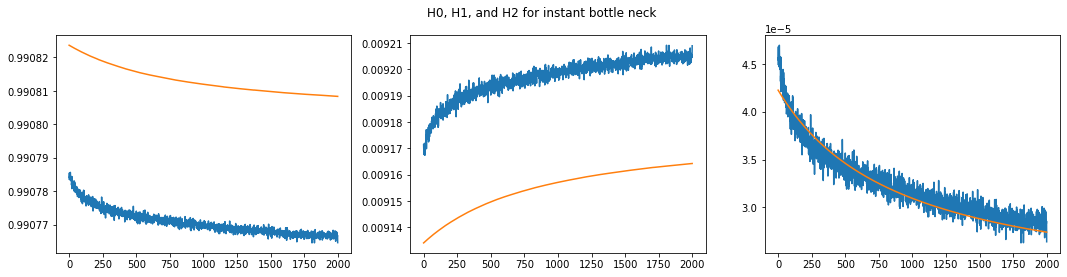

In [334]:
observed_hProbs_bottle_strong_short = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_strong_short[:,[1,2,3]])
expected_hProbs_bottle_strong_short = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_strong_short])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strong_short[:,x])
    axs[x].plot(expected_hProbs_bottle_strong_short[:,x])
plt.show()

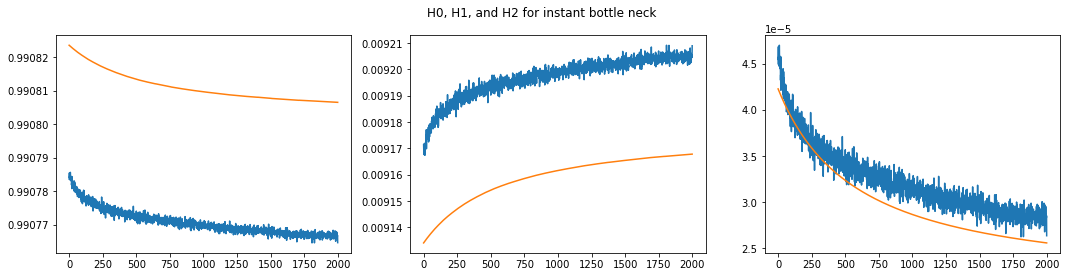

In [336]:
observed_hProbs_bottle_strong_short = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_strong_short[:,[1,2,3]])
expected_hProbs_bottle_strong_short = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_strong_short])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strong_short[:,x])
    axs[x].plot(expected_hProbs_bottle_strong_short[:,x])
plt.show()

##### weak long bottltneck sim function defined (also needs better name) 

still using parameters to match prob of coal during bottleneck in instantaneous and strong bottleneck models above

tBottle = 0.5
tDuration = 0.9
Nbottle = 0.9 * Ne

duration Nb = 1/10 Na, so Tduration = 1/10. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above. 


In [79]:
test_bottle_weak_long = sim_bottleneck([0,0.5,0.9,0.9])
test_bottle_weak_long = np.array(test_bottle_weak_long)

In [80]:
print(test_bottle_weak_long.tolist())

[[1.0, 49316477.0, 676978.0, 4545.0, 0.006860954438177527], [2.0, 49316596.0, 676740.0, 4664.0, 0.006860954438177527], [3.0, 49316597.0, 676738.0, 4665.0, 0.006860954438177527], [4.0, 49316573.0, 676786.0, 4641.0, 0.006860954438177527], [5.0, 49316562.0, 676808.0, 4630.0, 0.006860954438177527], [6.0, 49316437.0, 677058.0, 4505.0, 0.006860954438177527], [7.0, 49316578.0, 676776.0, 4646.0, 0.006860954438177527], [8.0, 49316495.0, 676942.0, 4563.0, 0.006860954438177527], [9.0, 49316553.0, 676826.0, 4621.0, 0.006860954438177527], [10.0, 49316468.0, 676996.0, 4536.0, 0.006860954438177527], [11.0, 49316523.0, 676886.0, 4591.0, 0.006860954438177527], [12.0, 49316484.0, 676964.0, 4552.0, 0.006860954438177527], [13.0, 49316535.0, 676862.0, 4603.0, 0.006860954438177527], [14.0, 49316469.0, 676994.0, 4537.0, 0.006860954438177527], [15.0, 49316528.0, 676876.0, 4596.0, 0.006860954438177527], [16.0, 49316364.0, 677204.0, 4432.0, 0.006860954438177527], [17.0, 49316377.0, 677178.0, 4445.0, 0.006860954

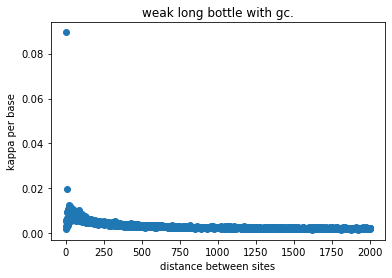

[0.0017371278522444475, 0.003877381259104161, 98.90644849561335]


In [81]:
res_bottle_weak_long = [find_max_like_single_dist(x) for x in test_bottle_weak_long[:]]
x,y = zip(*res_bottle_weak_long)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("weak long bottle with gc.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_weak_long))

In [398]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0017371278522444475 /   0.006860954438177527 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.003877381259104161 /   0.006860954438177527 )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.0574422914883022
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.146421377779377


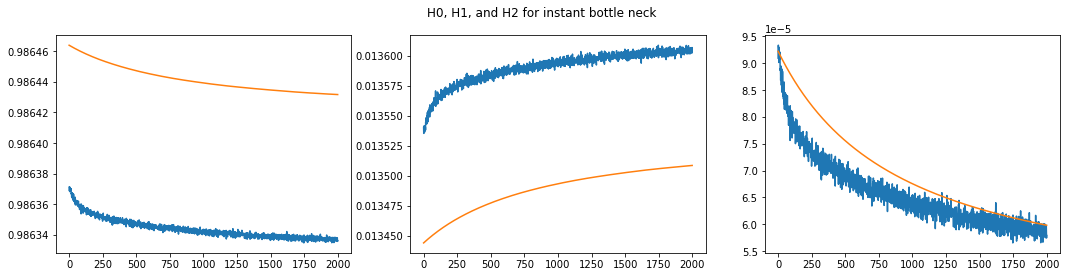

In [391]:
observed_hProbs_bottle_weak_long = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_weak_long[:,[1,2,3]])
expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_weak_long])
#expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_weak_long])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_weak_long[:,x])
    axs[x].plot(expected_hProbs_bottle_weak_long[:,x])
plt.show()

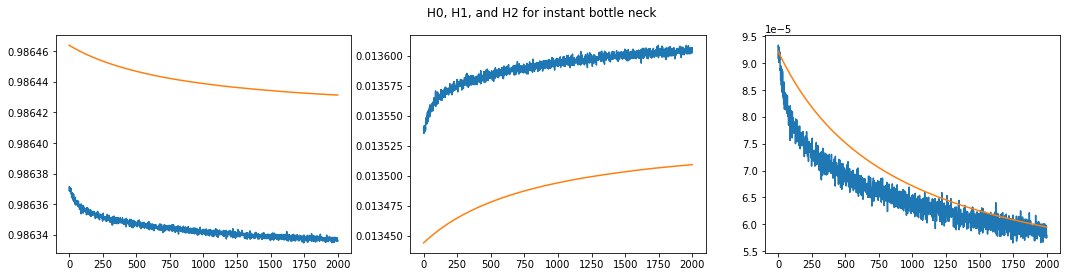

In [332]:
observed_hProbs_bottle_weak_long = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_weak_long[:,[1,2,3]])
expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_weak_long])
#expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_weak_long])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_weak_long[:,x])
    axs[x].plot(expected_hProbs_bottle_weak_long[:,x])
plt.show()

##### mid strength bottleneck 

still using parameters to match prob of coal during bottleneck in instantaneous and strong bottleneck models above


duration Nb = 1/2 Na, so Tduration = 1/2. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above. 


In [82]:
test_bottle_mid_strength = sim_bottleneck([0,0.5,0.5,0.5])
test_bottle_mid_strength = np.array(test_bottle_mid_strength)

In [83]:
print(test_bottle_mid_strength.tolist())

[[1.0, 49427557.0, 567034.0, 3409.0, 0.005738749549981999], [2.0, 49427362.0, 567424.0, 3214.0, 0.005738749549981999], [3.0, 49427460.0, 567228.0, 3312.0, 0.005738749549981999], [4.0, 49427414.0, 567320.0, 3266.0, 0.005738749549981999], [5.0, 49427398.0, 567352.0, 3250.0, 0.005738749549982], [6.0, 49427398.0, 567352.0, 3250.0, 0.005738749549982], [7.0, 49427512.0, 567124.0, 3364.0, 0.005738749549982], [8.0, 49427343.0, 567462.0, 3195.0, 0.005738749549982], [9.0, 49427384.0, 567380.0, 3236.0, 0.005738749549981999], [10.0, 49427322.0, 567504.0, 3174.0, 0.005738749549982], [11.0, 49427331.0, 567486.0, 3183.0, 0.005738749549982], [12.0, 49427317.0, 567514.0, 3169.0, 0.005738749549982], [13.0, 49427363.0, 567422.0, 3215.0, 0.005738749549981999], [14.0, 49427424.0, 567300.0, 3276.0, 0.005738749549982], [15.0, 49427347.0, 567454.0, 3199.0, 0.005738749549982], [16.0, 49427244.0, 567660.0, 3096.0, 0.005738749549981999], [17.0, 49427300.0, 567548.0, 3152.0, 0.005738749549982], [18.0, 49427279.0,

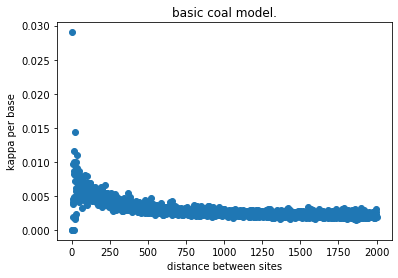

[0.0018065333607869107, 0.002910487460340274, 113.9405637226152]


In [84]:


res_bottle_mid_strength = [find_max_like_single_dist(x) for x in test_bottle_mid_strength[:]]
x,y = zip(*res_bottle_mid_strength)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_mid_strength))

In [399]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0018065333607869107 /  0.005738739549581983  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.002910487460340274  / 0.005738739549581983   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.3147370398682712
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.0288202930714572


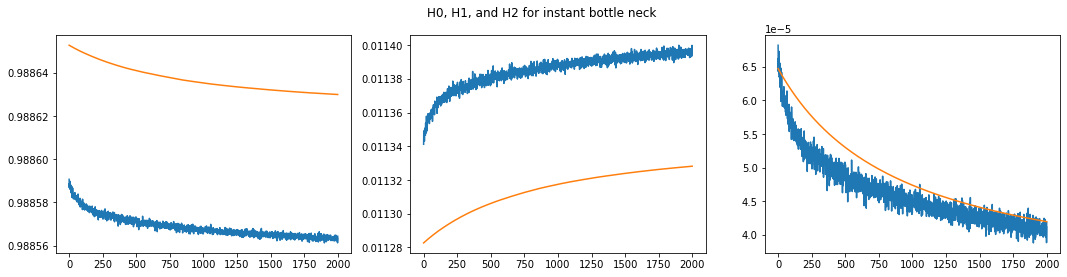

In [337]:
observed_hProbs_bottle_mid_strength = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_mid_strength[:,[1,2,3]])
expected_hProbs_bottle_mid_strength = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_mid_strength])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_mid_strength[:,x])
    axs[x].plot(expected_hProbs_bottle_mid_strength[:,x])
plt.show()

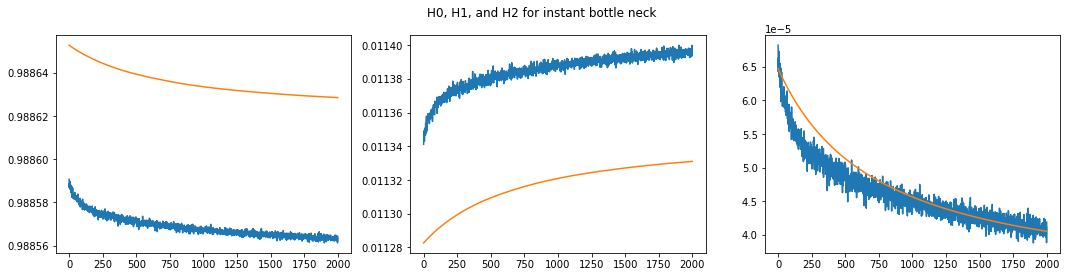

In [333]:
observed_hProbs_bottle_mid_strength = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_mid_strength[:,[1,2,3]])
expected_hProbs_bottle_mid_strength = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_mid_strength])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_mid_strength[:,x])
    axs[x].plot(expected_hProbs_bottle_mid_strength[:,x])
plt.show()

##### bottleneck model scaled results combined

In [177]:
scaledRes_bottle_strong_short = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_strong_short,test_bottle_strong_short[:,-1],scaled_rho_expected))];
scaledRes_bottle_weak_long = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_weak_long,test_bottle_weak_long[:,-1],scaled_rho_expected))];
scaledRes_bottle_mid_strength = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_mid_strength,test_bottle_mid_strength[:,-1],scaled_rho_expected))];


In [178]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_bottle_strong_short[-6:-1]])
print([a[1] for a in scaledRes_bottle_weak_long[-6:-1]])
print([a[1] for a in scaledRes_bottle_mid_strength[-6:-1]])
print("true rho/theta = 0.239437")


true rho/theta = 0.239437
[0.3196545858582738, 0.29717334908908044, 0.336856706832323, 0.3178786194944107, 0.3203181311666668]
[1.1812041177290844, 1.0380437882822073, 1.1005366154302234, 0.9227269149008653, 1.0827938432025626]
[1.3218037777311722, 1.233870039167454, 1.2447504219298426, 1.5689025039728246, 1.2027596789923964]
true rho/theta = 0.239437


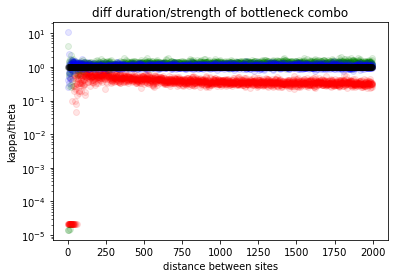

In [191]:


x,y = zip(*scaledRes_bottle_strong_short)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_mid_strength)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_weak_long)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

# x,y = zip(*scaled_rho_expected)
# plt.scatter(x,y,color='black')
x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.yscale("log")
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff duration/strength of bottleneck combo")
plt.show()

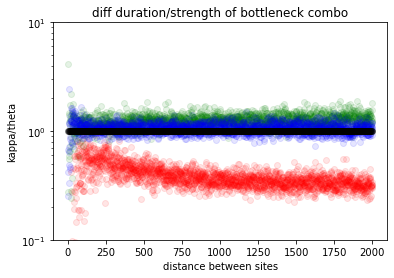

In [193]:
x,y = zip(*scaledRes_bottle_strong_short)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_mid_strength)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_weak_long)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

# x,y = zip(*scaled_rho_expected)
# plt.scatter(x,y,color='black')
x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.yscale("log")
plt.ylim(1e-1,1e1)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff duration/strength of bottleneck combo")
plt.show()

## Exponential growth model 

##### exponential growth model defined

In [152]:
def sim_exponential_growth(args):
    itt, c, Ta = args  
    #itt = identifier, c = reduction in pop size. I.e. Na = c*Ne
    # Ta = time when pop size reaches Na in coal time units
        
    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    Na = Ne*c
    ta = 2*Ne*Ta
    growth_rate = -math.log(1/10)/ta
    

    

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne,growth_rate=growth_rate)
    demography.add_population_parameters_change(time=ta,initial_size=Na)


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### __Strong and very recent exponential growth__

pop reduces to 1/10 the size 0.025 (2N) generations in the past

In [153]:
veryRecentExponential = sim_exponential_growth([0,1/10,0.05])
veryRecentExponential = np.array(veryRecentExponential)

In [154]:
print(veryRecentExponential.tolist())

[[1.0, 49945686.0, 52300.0, 14.0, 0.0005233009320372814], [2.0, 49945694.0, 52284.0, 22.0, 0.0005233009320372814], [3.0, 49945682.0, 52308.0, 10.0, 0.0005233009320372815], [4.0, 49945684.0, 52304.0, 12.0, 0.0005233009320372815], [5.0, 49945686.0, 52300.0, 14.0, 0.0005233009320372814], [6.0, 49945691.0, 52290.0, 19.0, 0.0005233009320372815], [7.0, 49945689.0, 52294.0, 17.0, 0.0005233009320372815], [8.0, 49945682.0, 52308.0, 10.0, 0.0005233009320372815], [9.0, 49945698.0, 52276.0, 26.0, 0.0005233009320372815], [10.0, 49945692.0, 52287.0, 21.0, 0.0005233109324372975], [11.0, 49945683.0, 52305.0, 12.0, 0.0005233109324372975], [12.0, 49945681.0, 52309.0, 10.0, 0.0005233109324372975], [13.0, 49945684.0, 52303.0, 13.0, 0.0005233109324372975], [14.0, 49945686.0, 52299.0, 15.0, 0.0005233109324372974], [15.0, 49945685.0, 52301.0, 14.0, 0.0005233109324372974], [16.0, 49945690.0, 52291.0, 19.0, 0.0005233109324372975], [17.0, 49945680.0, 52311.0, 9.0, 0.0005233109324372975], [18.0, 49945692.0, 5228

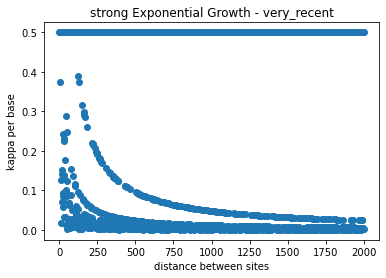

[1e-07, 0.5, 12.39607168730506]


In [155]:
res_exponential_singleItt = [find_max_like_single_dist(x) for x in veryRecentExponential[:]]
x,y = zip(*res_exponential_singleItt)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("strong Exponential Growth - very_recent")
plt.show()
print(HeRho_estimate_one_chromosome(veryRecentExponential))

In [400]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 1e-07 /  0.0005233109324372974  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (   0.5 / 0.0005233109324372974   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.0007980858662332102
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1938.2085322806531


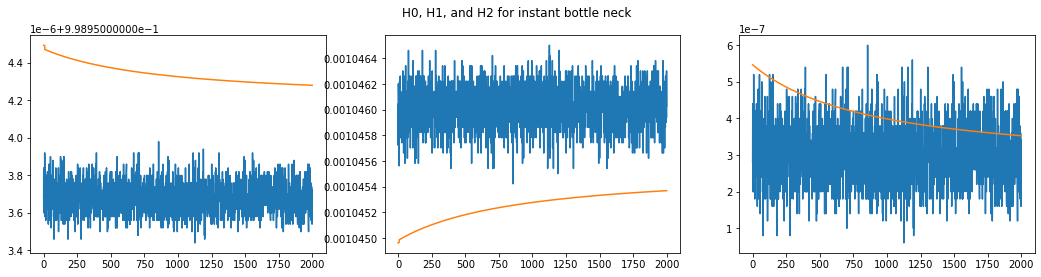

In [302]:
observed_hProbs_bottle_veryRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,veryRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_veryRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in veryRecentExponential])

fig, axs = plt.subplots(1,3,figs
                        ize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_veryRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_veryRecentExponential[:,x])
plt.show()

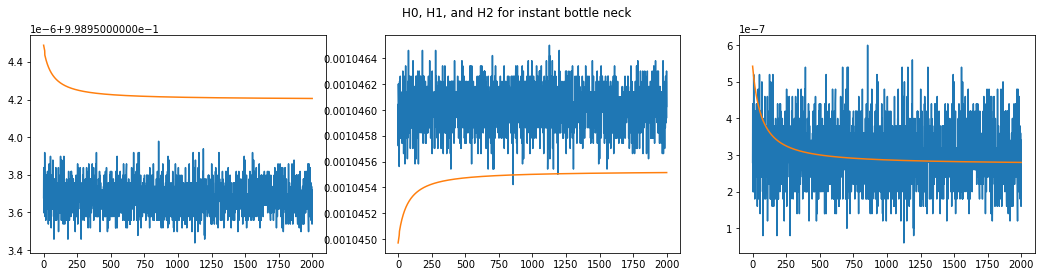

In [338]:
observed_hProbs_bottle_veryRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,veryRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_veryRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in veryRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_veryRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_veryRecentExponential[:,x])
plt.show()

##### __Strong and recent exponential growth__

pop reduces to 1/10 the size 0.5 (2N) generations in the past

In [156]:
strongRecentExponential = sim_exponential_growth([0,1/10,0.5])

In [157]:
strongRecentExponential = np.array(strongRecentExponential)

In [158]:
print(strongRecentExponential.tolist())

[[1.0, 49777952.0, 219742.0, 306.0, 0.002203628145125805], [2.0, 49777977.0, 219692.0, 331.0, 0.002203628145125805], [3.0, 49777959.0, 219728.0, 313.0, 0.0022036281451258046], [4.0, 49777957.0, 219732.0, 311.0, 0.002203628145125805], [5.0, 49777980.0, 219686.0, 334.0, 0.002203628145125805], [6.0, 49777946.0, 219754.0, 300.0, 0.002203628145125805], [7.0, 49777982.0, 219682.0, 336.0, 0.002203628145125805], [8.0, 49777971.0, 219704.0, 325.0, 0.002203628145125805], [9.0, 49777955.0, 219736.0, 309.0, 0.002203628145125805], [10.0, 49777941.0, 219764.0, 295.0, 0.002203628145125805], [11.0, 49777988.0, 219670.0, 342.0, 0.002203628145125805], [12.0, 49777936.0, 219774.0, 290.0, 0.002203628145125805], [13.0, 49777983.0, 219680.0, 337.0, 0.002203628145125805], [14.0, 49777960.0, 219726.0, 314.0, 0.002203628145125805], [15.0, 49777958.0, 219731.0, 311.0, 0.002203618144725789], [16.0, 49777971.0, 219705.0, 324.0, 0.002203618144725789], [17.0, 49777940.0, 219767.0, 293.0, 0.002203618144725789], [18.

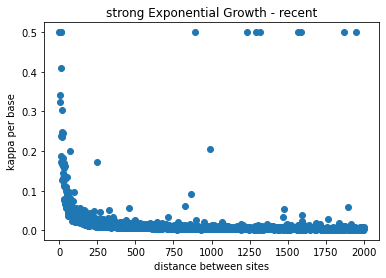

[0.0011776855035382267, 0.19794461461072127, 10.0]


In [159]:
res_exponential_recent = [find_max_like_single_dist(x) for x in strongRecentExponential[:]]
x,y = zip(*res_exponential_recent)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("strong Exponential Growth - recent")
plt.show()
print(HeRho_estimate_one_chromosome(strongRecentExponential))

In [401]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0011776855035382267 /  0.0022036181447257887  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.19794461461072127  / 0.0022036181447257887   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   2.232042279870829
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   182.2206767538024


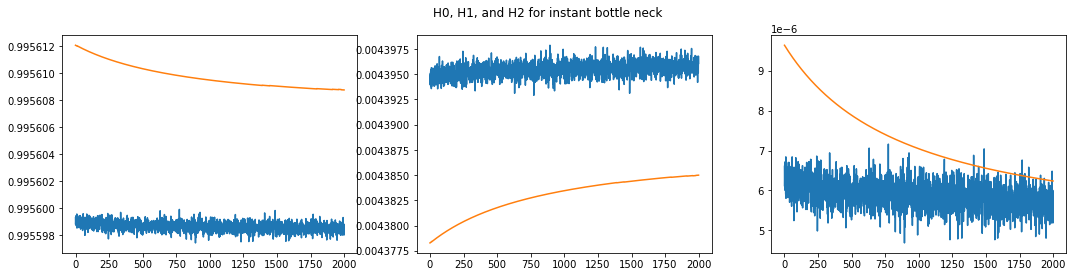

In [303]:
observed_hProbs_bottle_strongRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_strongRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in strongRecentExponential])


fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongRecentExponential[:,x])
plt.show()

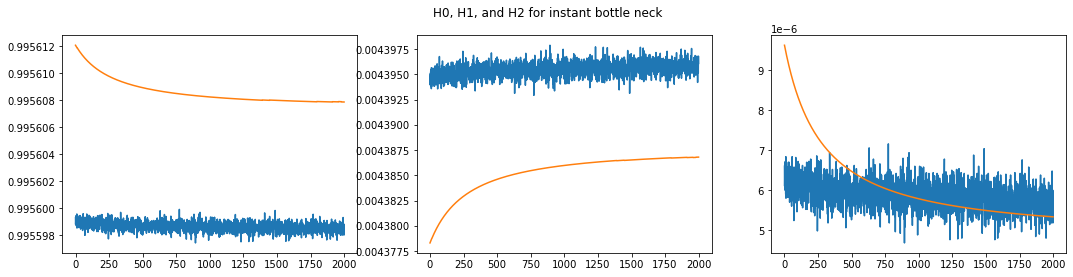

In [339]:
observed_hProbs_bottle_strongRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_strongRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in strongRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongRecentExponential[:,x])
plt.show()

##### __Strong and older exponential growth__
Pop size reduces (pastward) to 1/10th the size at 2*2Ne generations in the past 

In [160]:
strongOlderExponential = sim_exponential_growth([0,1/10,2.0])

In [161]:
strongOlderExponential = np.array(strongOlderExponential)

In [162]:
print(strongOlderExponential.tolist())

[[1.0, 49592405.0, 404380.0, 1215.0, 0.00406826273050922], [2.0, 49592411.0, 404368.0, 1221.0, 0.00406826273050922], [3.0, 49592356.0, 404478.0, 1166.0, 0.00406826273050922], [4.0, 49592428.0, 404334.0, 1238.0, 0.00406826273050922], [5.0, 49592434.0, 404322.0, 1244.0, 0.00406826273050922], [6.0, 49592429.0, 404332.0, 1239.0, 0.00406826273050922], [7.0, 49592423.0, 404344.0, 1233.0, 0.0040682627305092195], [8.0, 49592442.0, 404306.0, 1252.0, 0.00406826273050922], [9.0, 49592432.0, 404326.0, 1242.0, 0.00406826273050922], [10.0, 49592359.0, 404472.0, 1169.0, 0.00406826273050922], [11.0, 49592395.0, 404400.0, 1205.0, 0.00406826273050922], [12.0, 49592406.0, 404378.0, 1216.0, 0.0040682627305092195], [13.0, 49592360.0, 404470.0, 1170.0, 0.00406826273050922], [14.0, 49592432.0, 404326.0, 1242.0, 0.00406826273050922], [15.0, 49592351.0, 404488.0, 1161.0, 0.00406826273050922], [16.0, 49592398.0, 404394.0, 1208.0, 0.00406826273050922], [17.0, 49592396.0, 404398.0, 1206.0, 0.00406826273050922], [

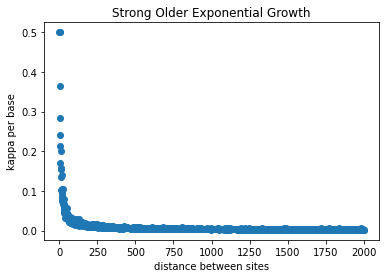

[0.0016158945005049759, 0.10484021105122901, 10.0]


In [163]:
res_exponential_older = [find_max_like_single_dist(x) for x in strongOlderExponential[:]]
x,y = zip(*res_exponential_older)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("Strong Older Exponential Growth")
plt.show()
print(HeRho_estimate_one_chromosome(strongOlderExponential))

In [402]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0016158945005049759 / 0.004068272730909236   )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.10484021105122901   /  0.004068272730909236  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.6588700663492364
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   52.27669597667063


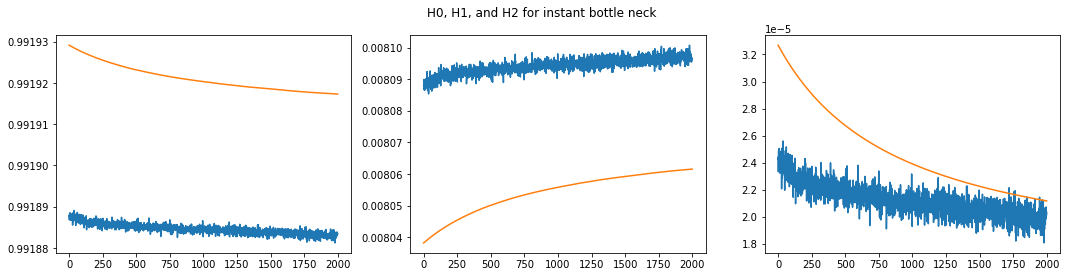

In [341]:
observed_hProbs_bottle_strongOlderExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongOlderExponential[:,[1,2,3]])
expected_hProbs_bottle_strongOlderExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in strongOlderExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongOlderExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongOlderExponential[:,x])
plt.show()

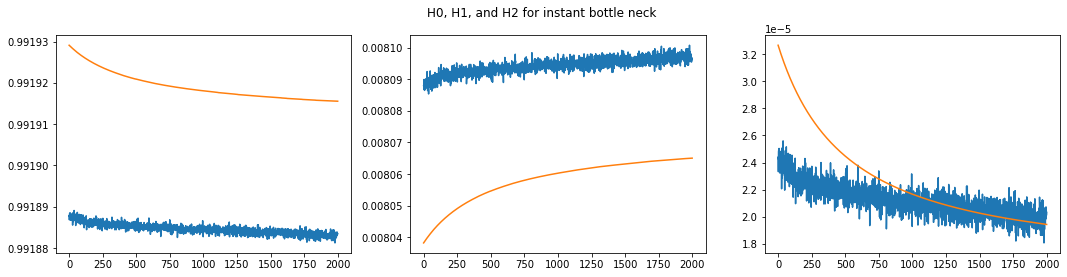

In [340]:
observed_hProbs_bottle_strongOlderExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongOlderExponential[:,[1,2,3]])
expected_hProbs_bottle_strongOlderExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in strongOlderExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongOlderExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongOlderExponential[:,x])
plt.show()

##### exponential scaled results combined

In [105]:
#[two_locus_het_probs(0.0071,0.0017,x) for x in range(1,100)]

In [173]:
scaledRes_exponential_veryrecent = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_singleItt,veryRecentExponential[:,-1],scaled_rho_expected))];
scaledRes_exponential_recent = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_recent,strongRecentExponential[:,-1],scaled_rho_expected))];
scaledRes_exponential_older = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_older,strongOlderExponential[:,-1],scaled_rho_expected))];


In [174]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_exponential_veryrecent[-6:-1]])
print([a[1] for a in scaledRes_exponential_recent[-6:-1]])
print([a[1] for a in scaledRes_exponential_older[-6:-1]])

true rho/theta = 0.239437
[3262.7616793940715, 9.961814091939624, 9.957738691530599, 3263.655727524011, 38.71399220913362]
[4.311941365979336, 4.645078749464409, 5.618732453236135, 5.961230733673752, 3.4288480025861037]
[1.987691107172837, 1.7100369350888494, 2.1222359100468253, 1.9222305836646871, 2.078195570461118]


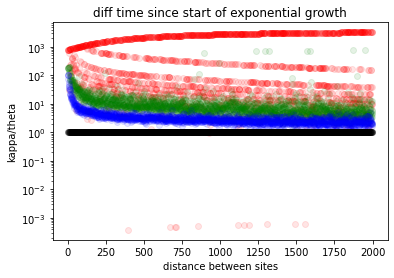

In [194]:
x,y = zip(*scaledRes_exponential_veryrecent)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_recent)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_older)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.yscale("log")
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff time since start of exponential growth")
plt.show()

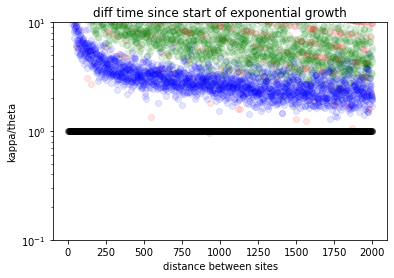

In [195]:
x,y = zip(*scaledRes_exponential_veryrecent)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_recent)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_older)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.yscale("log")
plt.ylim(1e-1,1e1)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff time since start of exponential growth")
plt.show()

## Admixture Model 

##### sim_admixture defined

In [262]:
def sim_admixture(args):
    itt, Tadmix, Tdiv = args
    itt, c, Ta = args  
    #itt = identifier
    #Tadmix is time to admixture event in coal units
    #Tdiv is duration (!) of the divergence period 
        
    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 1000
    
    tadmix = Tadmix*2*Ne
    tanc = (Tadmix + Tdiv)*2*Ne
    
    
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=Ne)
    demography.add_population(name="B", initial_size=Ne)
    demography.add_population(name="ADMIX", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    demography.add_admixture(
        time=tadmix, derived="ADMIX", ancestral=["A", "B"], proportions=[0.5, 0.5])
    demography.add_population_split(time=tanc, derived=["A", "B"], ancestral="ANC")


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples={"ADMIX":1},
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

In [128]:
#sim_admixture(["itt1",0.5,2])

##### __admixture model 1__
time to admixture is (0.01) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.01 + 2.0) 2 Ne gens

In [263]:
test_admixture_1 = sim_admixture([0,0.01,2.0])
test_admixture_1 = np.array(test_admixture_1)

In [264]:
print(test_admixture_1.tolist())

[[1.0, 48582983.0, 1400766.0, 15251.0, 0.014312966259325186], [2.0, 48582789.0, 1401154.0, 15057.0, 0.014312966259325186], [3.0, 48582639.0, 1401454.0, 14907.0, 0.014312966259325186], [4.0, 48582765.0, 1401202.0, 15033.0, 0.014312966259325186], [5.0, 48582695.0, 1401342.0, 14963.0, 0.014312966259325186], [6.0, 48582817.0, 1401098.0, 15085.0, 0.014312966259325186], [7.0, 48582625.0, 1401482.0, 14893.0, 0.014312966259325188], [8.0, 48582574.0, 1401584.0, 14842.0, 0.014312966259325188], [9.0, 48582638.0, 1401456.0, 14906.0, 0.014312966259325186], [10.0, 48582657.0, 1401418.0, 14925.0, 0.014312966259325186], [11.0, 48582521.0, 1401690.0, 14789.0, 0.014312966259325186], [12.0, 48582539.0, 1401654.0, 14807.0, 0.014312966259325186], [13.0, 48582599.0, 1401534.0, 14867.0, 0.014312966259325186], [14.0, 48582700.0, 1401332.0, 14968.0, 0.014312966259325186], [15.0, 48582634.0, 1401463.0, 14903.0, 0.01431297625952519], [16.0, 48582585.0, 1401561.0, 14854.0, 0.01431297625952519], [17.0, 48582608.0,

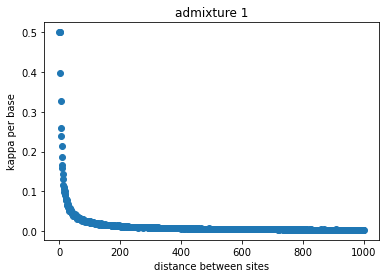

[0.0011588845022791542, 0.11299976146830062, 10.0]


In [265]:
res_admixture_1 = [find_max_like_single_dist(x) for x in test_admixture_1[:]]
x,y = zip(*res_admixture_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admixture 1")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_1))

In [403]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0011588845022791542 /   0.014312956259125183 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.11299976146830062  / 0.014312956259125183   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.3381584454884942
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   16.015425702418224


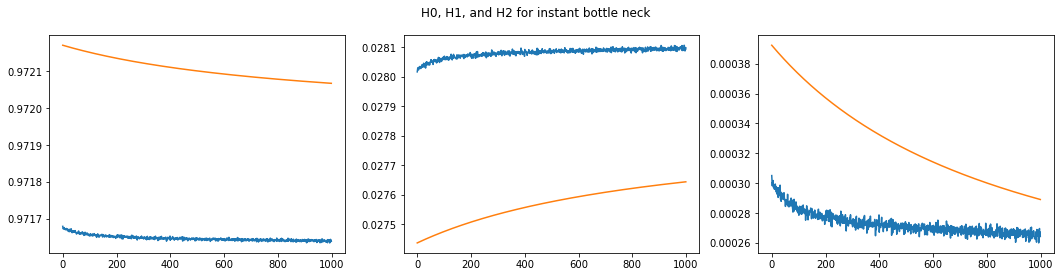

In [343]:
observed_hProbs_admixture_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_1[:,[1,2,3]])
expected_hProbs_admixture_1 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_1[:,x])
    axs[x].plot(expected_hProbs_admixture_1[:,x])
plt.show()

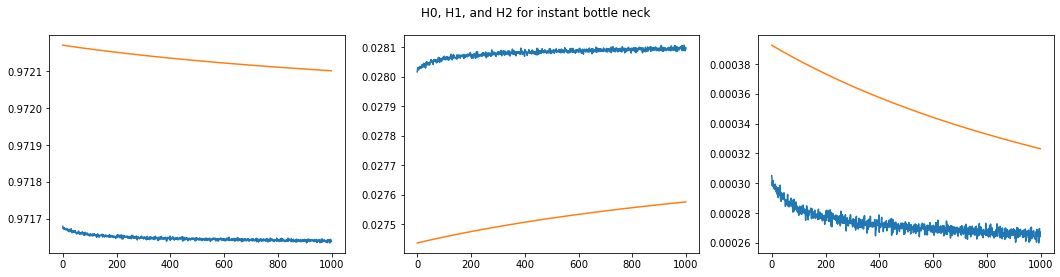

In [342]:
observed_hProbs_admixture_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_1[:,[1,2,3]])
expected_hProbs_admixture_1 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_1[:,x])
    axs[x].plot(expected_hProbs_admixture_1[:,x])
plt.show()

##### __admixture model 2__
time to admixture is (0.1) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.1 + 2.0) 2 Ne gens

In [266]:
test_admixture_2 = sim_admixture([0,0.1,2.0])
test_admixture_2 = np.array(test_admixture_2)

In [267]:
print(test_admixture_2.tolist())

[[1.0, 48682089.0, 1302680.0, 14231.0, 0.013311686233724675], [2.0, 48681914.0, 1303030.0, 14056.0, 0.013311686233724675], [3.0, 48681883.0, 1303092.0, 14025.0, 0.013311686233724675], [4.0, 48681899.0, 1303060.0, 14041.0, 0.013311686233724675], [5.0, 48681871.0, 1303116.0, 14013.0, 0.013311686233724675], [6.0, 48681787.0, 1303284.0, 13929.0, 0.013311686233724675], [7.0, 48681757.0, 1303344.0, 13899.0, 0.013311686233724675], [8.0, 48681881.0, 1303096.0, 14023.0, 0.013311686233724675], [9.0, 48681703.0, 1303452.0, 13845.0, 0.013311686233724675], [10.0, 48681846.0, 1303166.0, 13988.0, 0.013311686233724675], [11.0, 48681926.0, 1303006.0, 14068.0, 0.013311686233724675], [12.0, 48681825.0, 1303208.0, 13967.0, 0.013311686233724675], [13.0, 48681927.0, 1303004.0, 14069.0, 0.013311686233724675], [14.0, 48681892.0, 1303074.0, 14034.0, 0.013311686233724675], [15.0, 48682006.0, 1302846.0, 14148.0, 0.013311686233724675], [16.0, 48681816.0, 1303226.0, 13958.0, 0.013311686233724675], [17.0, 48681740.

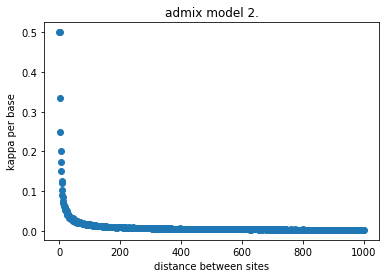

[0.0012766834925063658, 0.0722595630748594, 10.0]


In [268]:
res_admixture_2 = [find_max_like_single_dist(x) for x in test_admixture_2[:]]
x,y = zip(*res_admixture_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 2.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_2))

In [404]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0012766834925063658 /   0.013311686233724675 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.0722595630748594   /  0.013311686233724675  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.4005526394867875
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   11.011654160188234


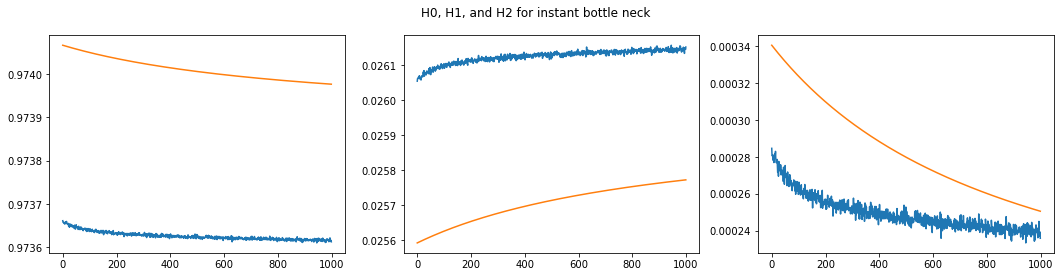

In [345]:
observed_hProbs_admixture_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_2[:,[1,2,3]])
expected_hProbs_admixture_2 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_2[:,x])
    axs[x].plot(expected_hProbs_admixture_2[:,x])
plt.show()

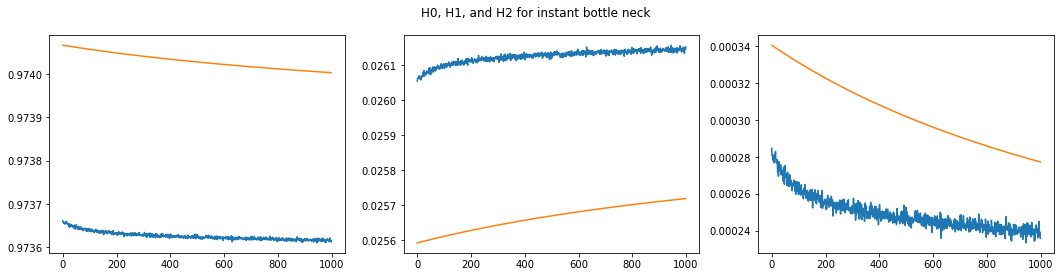

In [347]:
observed_hProbs_admixture_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_2[:,[1,2,3]])
expected_hProbs_admixture_2 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_2[:,x])
    axs[x].plot(expected_hProbs_admixture_2[:,x])
plt.show()

##### __admixture model 3__
time to admixture is (0.5) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.5 + 2.0) 2 Ne gens

In [269]:
test_admixture_3 = sim_admixture([0,0.5,2.0])
test_admixture_3 = np.array(test_admixture_3)

In [270]:
print(test_admixture_3.tolist())

[[1.0, 48849281.0, 1137088.0, 12631.0, 0.011623732474649493], [2.0, 48849422.0, 1136806.0, 12772.0, 0.011623732474649495], [3.0, 48849215.0, 1137220.0, 12565.0, 0.011623732474649493], [4.0, 48849290.0, 1137070.0, 12640.0, 0.011623732474649493], [5.0, 48849308.0, 1137034.0, 12658.0, 0.011623732474649493], [6.0, 48849206.0, 1137239.0, 12555.0, 0.01162372247444949], [7.0, 48849388.0, 1136875.0, 12737.0, 0.011623722474449488], [8.0, 48849276.0, 1137099.0, 12625.0, 0.011623722474449488], [9.0, 48849199.0, 1137253.0, 12548.0, 0.01162372247444949], [10.0, 48849074.0, 1137503.0, 12423.0, 0.01162372247444949], [11.0, 48849001.0, 1137649.0, 12350.0, 0.011623722474449488], [12.0, 48849082.0, 1137487.0, 12431.0, 0.01162372247444949], [13.0, 48848974.0, 1137703.0, 12323.0, 0.01162372247444949], [14.0, 48849106.0, 1137439.0, 12455.0, 0.011623722474449488], [15.0, 48849026.0, 1137599.0, 12375.0, 0.01162372247444949], [16.0, 48849138.0, 1137375.0, 12487.0, 0.01162372247444949], [17.0, 48849027.0, 1137

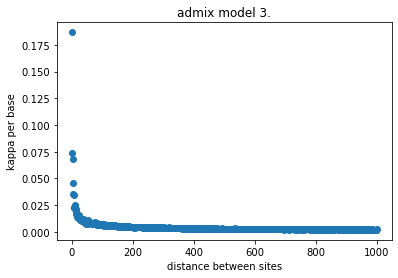

[0.001596693044461989, 0.0059305093693541285, 56.14140991902703]


In [271]:
res_admixture_3 = [find_max_like_single_dist(x) for x in test_admixture_3[:]]
x,y = zip(*res_admixture_3)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 3.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_3))

In [405]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.001596693044461989 /  0.011623712474249485  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.0059305093693541285   /  0.011623712474249485  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.5737015220746793
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.0349930704324073


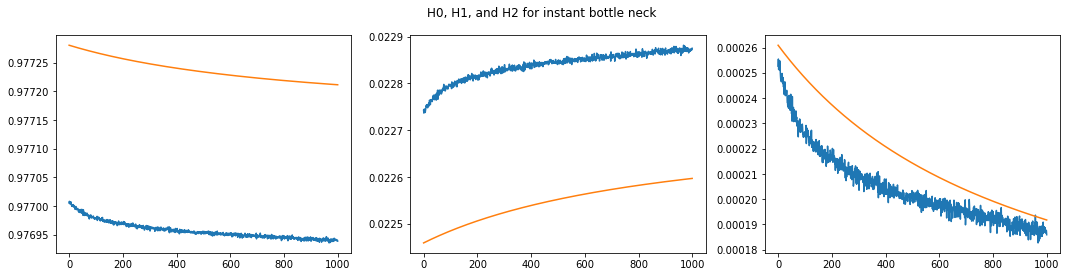

In [349]:
observed_hProbs_admixture_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_3[:,[1,2,3]])
expected_hProbs_admixture_3 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_3[:,x])
    axs[x].plot(expected_hProbs_admixture_3[:,x])
plt.show()

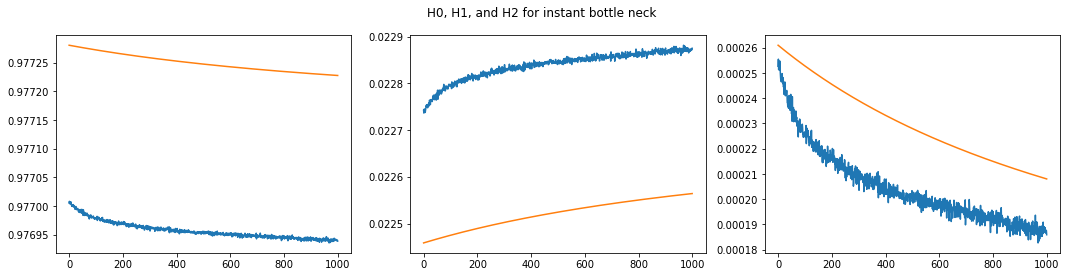

In [348]:
observed_hProbs_admixture_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_3[:,[1,2,3]])
expected_hProbs_admixture_3 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_3[:,x])
    axs[x].plot(expected_hProbs_admixture_3[:,x])
plt.show()

##### __admixture model 4__ 
time to admixture is (0.75) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.75 + 2.0) 2 Ne gens

In [272]:
test_admixture_4 = sim_admixture([0,0.75,2.0])
test_admixture_4 = np.array(test_admixture_4)

In [273]:
print(test_admixture_4.tolist())

[[1.0, 48996004.0, 991888.0, 11108.0, 0.010141242824856497], [2.0, 48995772.0, 992352.0, 10876.0, 0.010141242824856497], [3.0, 48995787.0, 992322.0, 10891.0, 0.010141242824856497], [4.0, 48995732.0, 992432.0, 10836.0, 0.010141242824856497], [5.0, 48995804.0, 992288.0, 10908.0, 0.010141242824856497], [6.0, 48995601.0, 992694.0, 10705.0, 0.010141242824856496], [7.0, 48995692.0, 992512.0, 10796.0, 0.010141242824856497], [8.0, 48995584.0, 992728.0, 10688.0, 0.010141242824856497], [9.0, 48995958.0, 991980.0, 11062.0, 0.010141242824856497], [10.0, 48995601.0, 992694.0, 10705.0, 0.010141242824856496], [11.0, 48995701.0, 992494.0, 10805.0, 0.010141242824856497], [12.0, 48995575.0, 992747.0, 10678.0, 0.010141232824656492], [13.0, 48995585.0, 992727.0, 10688.0, 0.010141232824656494], [14.0, 48995590.0, 992717.0, 10693.0, 0.010141232824656494], [15.0, 48995573.0, 992751.0, 10676.0, 0.010141232824656492], [16.0, 48995378.0, 993141.0, 10481.0, 0.010141232824656494], [17.0, 48995309.0, 993279.0, 104

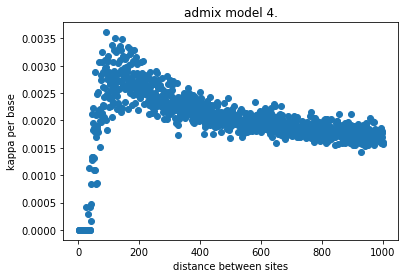

[0.000993572337309757, 0.0009267577786123572, 415.6294698938978]


In [274]:
res_admixture_4 = [find_max_like_single_dist(x) for x in test_admixture_4[:]]
x,y = zip(*res_admixture_4)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 4.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_4))

In [406]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      (  0.000993572337309757/   0.010141242824856497 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  0.0009267577786123572  /  0.010141242824856497  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.4091831460624863
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   0.18538106062221776


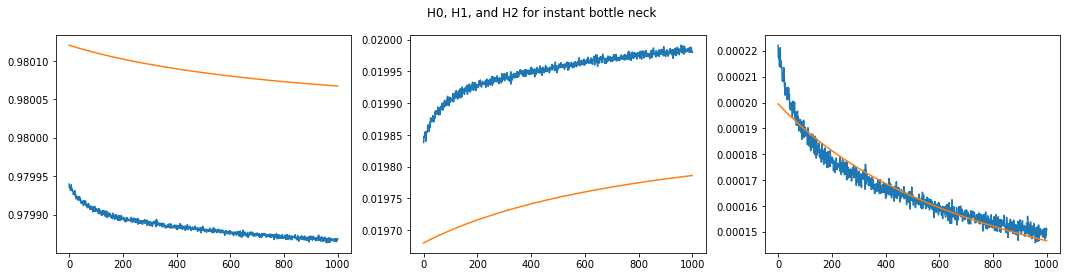

In [352]:
observed_hProbs_admixture_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_4[:,[1,2,3]])
expected_hProbs_admixture_4 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_4[:,x])
    axs[x].plot(expected_hProbs_admixture_4[:,x])
plt.show()

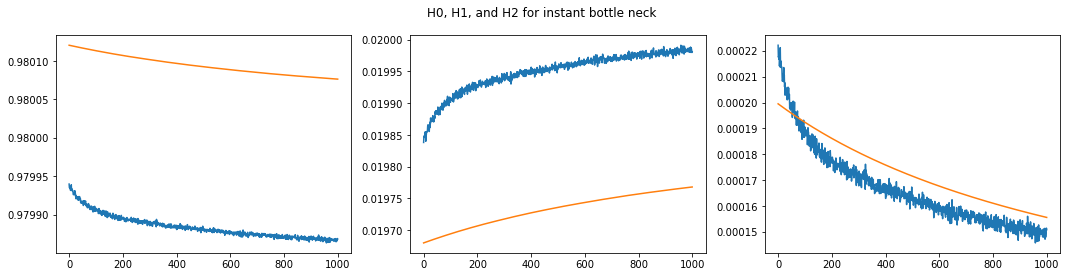

In [351]:
observed_hProbs_admixture_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_4[:,[1,2,3]])
expected_hProbs_admixture_4 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_4[:,x])
    axs[x].plot(expected_hProbs_admixture_4[:,x])
plt.show()

##### __admixture model 5__ 
time to admixture is (1.25) 2 Ne gens. This makes 1/2 prob of coal before admix
duration of divergence is (2.0)2 Ne gens
so time to divergence is (1.25 + 2.0) 2 Ne gens

In [275]:
test_admixture_5 = sim_admixture([0,1.25,2.0])
test_admixture_5 = np.array(test_admixture_5)

In [276]:
print(test_admixture_5.tolist())

[[1.0, 49096017.0, 893332.0, 9651.0, 0.009126522530450609], [2.0, 49095877.0, 893612.0, 9511.0, 0.009126522530450609], [3.0, 49095762.0, 893842.0, 9396.0, 0.009126522530450609], [4.0, 49095739.0, 893888.0, 9373.0, 0.009126522530450609], [5.0, 49095766.0, 893834.0, 9400.0, 0.009126522530450609], [6.0, 49095784.0, 893798.0, 9418.0, 0.00912652253045061], [7.0, 49095767.0, 893832.0, 9401.0, 0.009126522530450609], [8.0, 49095663.0, 894040.0, 9297.0, 0.009126522530450609], [9.0, 49095606.0, 894154.0, 9240.0, 0.009126522530450609], [10.0, 49095634.0, 894098.0, 9268.0, 0.009126522530450609], [11.0, 49095918.0, 893530.0, 9552.0, 0.009126522530450609], [12.0, 49095623.0, 894120.0, 9257.0, 0.00912652253045061], [13.0, 49095549.0, 894268.0, 9183.0, 0.009126522530450609], [14.0, 49095727.0, 893912.0, 9361.0, 0.00912652253045061], [15.0, 49095248.0, 894870.0, 8882.0, 0.00912652253045061], [16.0, 49095477.0, 894412.0, 9111.0, 0.009126522530450609], [17.0, 49095285.0, 894796.0, 8919.0, 0.0091265225304

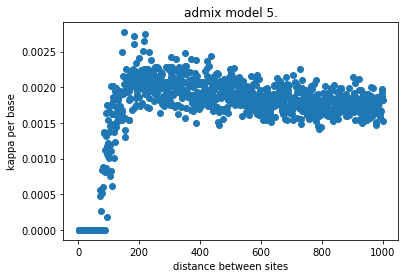

[0.0018260377806122844, 1e-07, 532.3621366797195]


In [277]:
res_admixture_5 = [find_max_like_single_dist(x) for x in test_admixture_5[:]]
x,y = zip(*res_admixture_5)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 5.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_5))

In [408]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0018260377806122844 /  0.009126522530450609  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (   1e-07 / 0.009126522530450609   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.8356296780387301
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   2.2227211096045703e-05


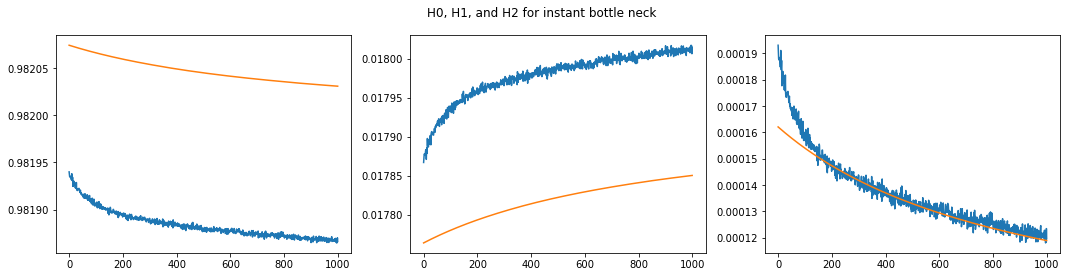

In [354]:
observed_hProbs_admixture_5 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_5[:,[1,2,3]])
expected_hProbs_admixture_5 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_5])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_5[:,x])
    axs[x].plot(expected_hProbs_admixture_5[:,x])
plt.show()

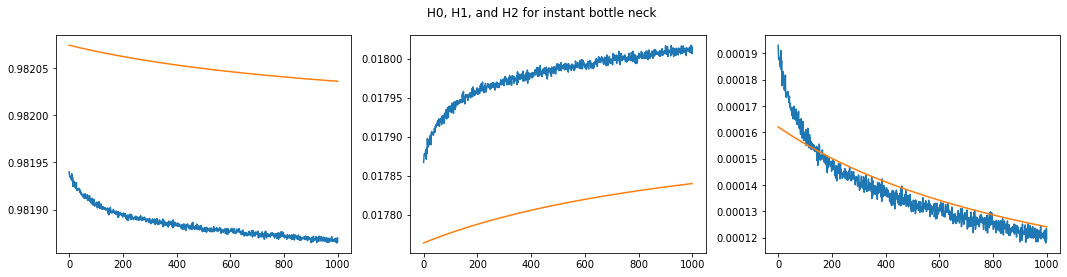

In [353]:
observed_hProbs_admixture_5 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_5[:,[1,2,3]])
expected_hProbs_admixture_5 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_5])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_5[:,x])
    axs[x].plot(expected_hProbs_admixture_5[:,x])
plt.show()

##### __admixture model 6__ 

time to admixture is (2.0) 2 Ne gens. 
duration of divergence is (2.0)2 Ne gens
so time to divergence is (2.0 + 2.0) 2 Ne gens

In [278]:
test_admixture_6 = sim_admixture([0,2.0,2.0])
test_admixture_6 = np.array(test_admixture_6)

In [279]:
print(test_admixture_6.tolist())

[[1.0, 49191386.0, 799868.0, 7746.0, 0.008153763075261505], [2.0, 49191293.0, 800054.0, 7653.0, 0.008153763075261505], [3.0, 49191240.0, 800160.0, 7600.0, 0.008153763075261505], [4.0, 49191330.0, 799980.0, 7690.0, 0.008153763075261505], [5.0, 49191406.0, 799828.0, 7766.0, 0.008153763075261505], [6.0, 49191196.0, 800248.0, 7556.0, 0.008153763075261505], [7.0, 49191368.0, 799904.0, 7728.0, 0.008153763075261505], [8.0, 49191229.0, 800182.0, 7589.0, 0.008153763075261505], [9.0, 49191144.0, 800352.0, 7504.0, 0.008153763075261505], [10.0, 49191287.0, 800066.0, 7647.0, 0.008153763075261505], [11.0, 49191064.0, 800512.0, 7424.0, 0.008153763075261505], [12.0, 49191225.0, 800190.0, 7585.0, 0.008153763075261505], [13.0, 49191082.0, 800476.0, 7442.0, 0.008153763075261505], [14.0, 49191181.0, 800278.0, 7541.0, 0.008153763075261505], [15.0, 49191014.0, 800612.0, 7374.0, 0.008153763075261505], [16.0, 49191141.0, 800358.0, 7501.0, 0.008153763075261505], [17.0, 49191052.0, 800536.0, 7412.0, 0.008153763

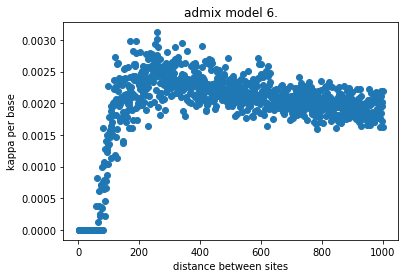

[0.0006554128281191522, 0.0008253332996785198, 2000.0]


In [280]:
res_admixture_6 = [find_max_like_single_dist(x) for x in test_admixture_6[:]]
x,y = zip(*res_admixture_6)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 6.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_6))

In [409]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0006554128281191522 /  0.008153743074861499  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.0008253332996785198   /  0.008153743074861499  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.33571236849871555
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   0.2053348425876008


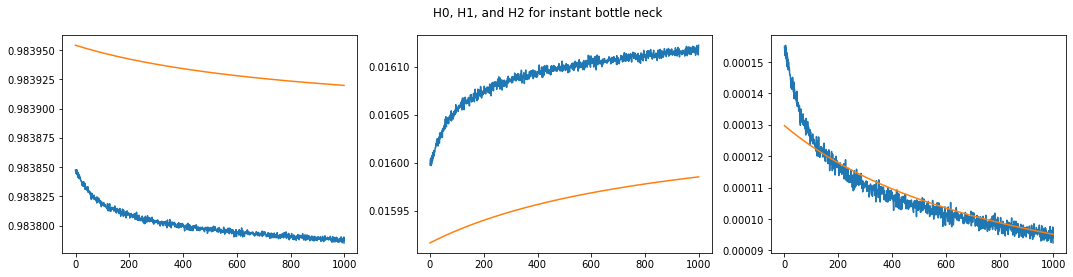

In [355]:
observed_hProbs_admixture_6 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_6[:,[1,2,3]])
expected_hProbs_admixture_6 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_6])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_6[:,x])
    axs[x].plot(expected_hProbs_admixture_6[:,x])
plt.show()

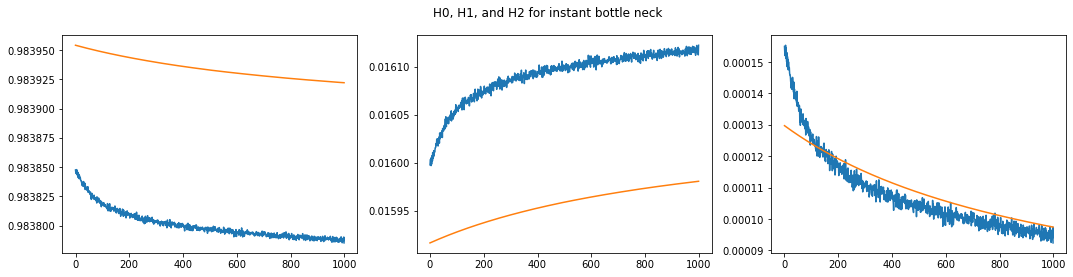

In [356]:
observed_hProbs_admixture_6 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_6[:,[1,2,3]])
expected_hProbs_admixture_6 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_6])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_6[:,x])
    axs[x].plot(expected_hProbs_admixture_6[:,x])
plt.show()

##### admixture scaled results combined

true scaled rho/theta = r/mu = 0.0017/0.0071 = 0.239437

In [259]:
# scaledRes_admixture_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_1,test_admixture_1[:,-1],scaled_rho_expected))];
# scaledRes_admixture_2 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_2,test_admixture_2[:,-1]))];
# scaledRes_admixture_3 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_3,test_admixture_3[:,-1]))];
# scaledRes_admixture_4 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_4,test_admixture_4[:,-1]))];
# scaledRes_admixture_5 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_5,test_admixture_5[:,-1]))];
# scaledRes_admixture_6 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_6,test_admixture_6[:,-1]))];

scaledRes_admixture_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_1,test_admixture_1[:,-1],scaled_rho_expected))];
scaledRes_admixture_2 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_2,test_admixture_2[:,-1],scaled_rho_expected))];
scaledRes_admixture_3 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_3,test_admixture_3[:,-1],scaled_rho_expected))];
scaledRes_admixture_4 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_4,test_admixture_4[:,-1],scaled_rho_expected))];
scaledRes_admixture_5 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_5,test_admixture_5[:,-1],scaled_rho_expected))];
scaledRes_admixture_6 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_6,test_admixture_6[:,-1],scaled_rho_expected))];


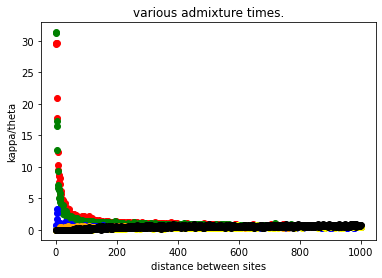

In [260]:
x,y = zip(*scaledRes_admixture_1)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_admixture_2)
plt.scatter(x,y,color='green')

x,y = zip(*scaledRes_admixture_3)
plt.scatter(x,y,color='blue')

x,y = zip(*scaledRes_admixture_4)
plt.scatter(x,y,color='orange')

x,y = zip(*scaledRes_admixture_5)
plt.scatter(x,y,color='yellow')

x,y = zip(*scaledRes_admixture_6)
plt.scatter(x,y,color='black')


plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various admixture times.")
plt.show()

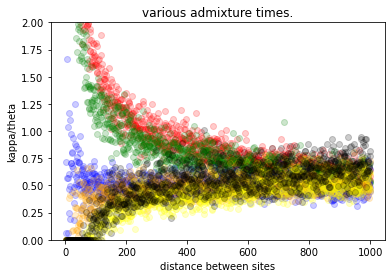

In [578]:
x,y = zip(*scaledRes_admixture_1)
plt.scatter(x,y,color='red',alpha=0.2,edgecolors=None)

x,y = zip(*scaledRes_admixture_2)
plt.scatter(x,y,color='green',alpha=0.2,edgecolors=None)

x,y = zip(*scaledRes_admixture_3)
plt.scatter(x,y,color='blue',alpha=0.2,edgecolors=None)

x,y = zip(*scaledRes_admixture_4)
plt.scatter(x,y,color='orange',alpha=0.2,edgecolors=None)

x,y = zip(*scaledRes_admixture_5)
plt.scatter(x,y,color='yellow',alpha=0.2,edgecolors=None)

x,y = zip(*scaledRes_admixture_6)
plt.scatter(x,y,color='black',alpha=0.2,edgecolors=None)

plt.ylim(0.0,2.0)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various admixture times.")
plt.show()

## structured pop with two demes and long-term migration

##### Sim_structured function defined

In [473]:
def sim_structured(args):
    itt, M = args
    #itt = identifier, 
    #M = (pastward) migration rate on coal scale
        
    theta = 0.0071
    rho = 0.0017
    gamma = 0.0035
    tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    m = M/(2*2*Ne)

    
    ##currently chosen to match probabilites to the instantaneous bottleneck model


    demography = msprime.Demography()
    a = demography.island_model([Ne,Ne],m)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples={"pop_0":1,"pop_1":0},
        demography=a,
        ploidy=2,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

#####  structured pop, single itt for range of M values: 
L = 50Mb for each replicate
M = {5e-15, 5e-6, 5e-5, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 5e0, 5e1, 5e2 }
M in coal time scale units. so per-gen rate is M/(4*Ne), converted in the sim function

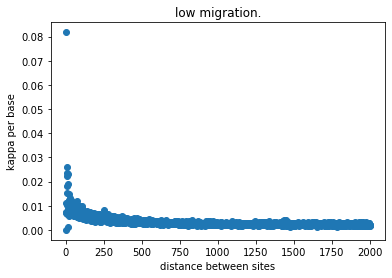

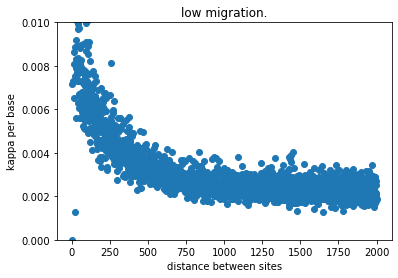

[0.001776436215348863, 0.004165901730371583, 89.33326580970738]


In [217]:
test_structure_1 = sim_structured([0,5e-6])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

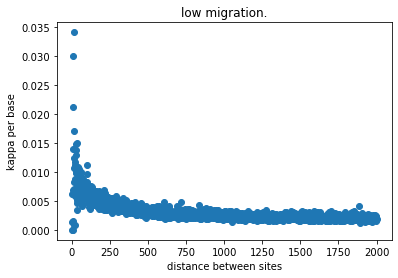

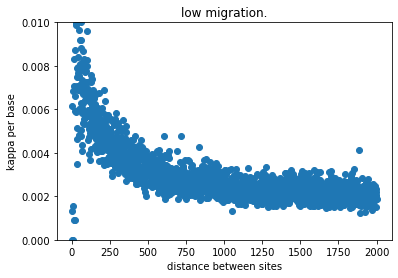

[0.0016461237280690224, 0.003619908770598432, 106.83674903771383]


In [218]:
test_structure_1 = sim_structured([0,5e-5])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

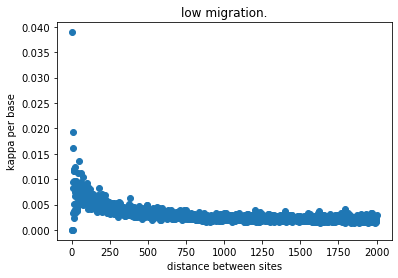

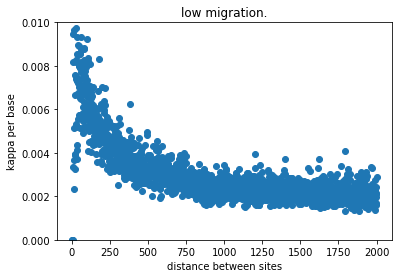

[0.0016229675458924084, 0.0034735021129172735, 113.45272275132784]


In [219]:
test_structure_1 = sim_structured([0,5e-4])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

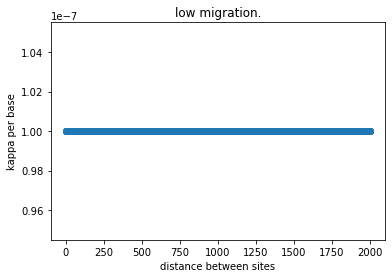

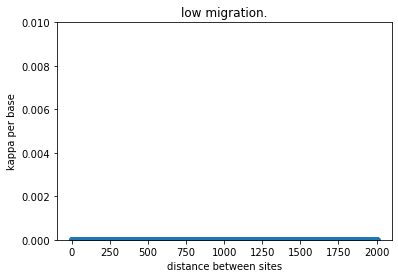

[1e-07, 1e-07, 10.0]


In [220]:
test_structure_1 = sim_structured([0,1e-3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

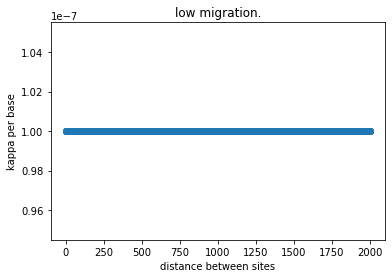

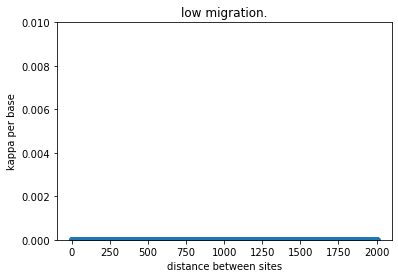

[1e-07, 1e-07, 10.0]


In [221]:
test_structure_1 = sim_structured([0,5e-3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

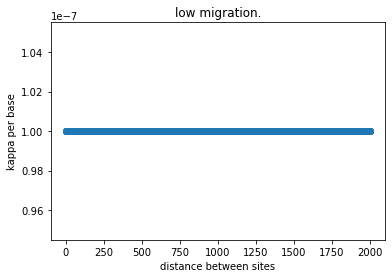

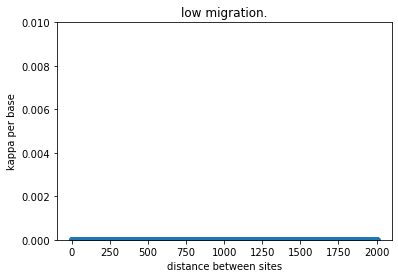

[1e-07, 1e-07, 10.0]


In [222]:
test_structure_1 = sim_structured([0,1e-2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

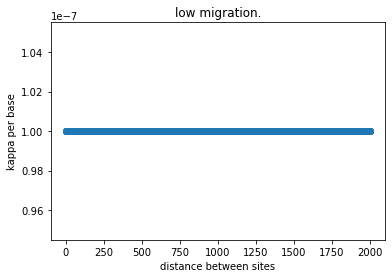

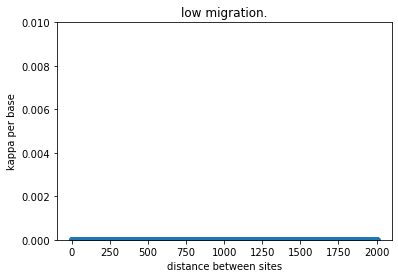

[1e-07, 1e-07, 10.0]


In [222]:
test_structure_1 = sim_structured([0,1e-2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

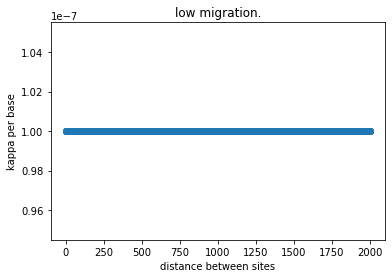

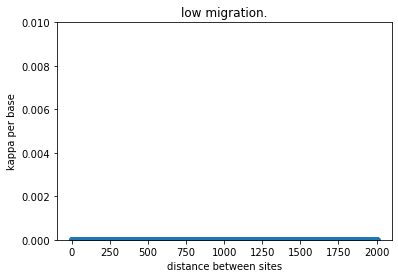

[1e-07, 1e-07, 10.0]


In [223]:
test_structure_1 = sim_structured([0,5e-2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

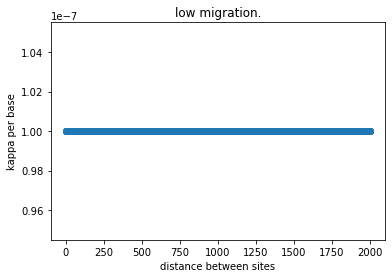

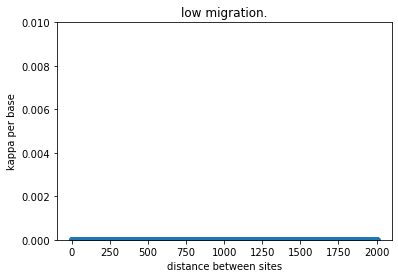

[1e-07, 1e-07, 10.0]


In [224]:
test_structure_1 = sim_structured([0,1e-1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

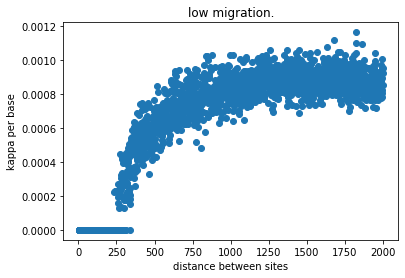

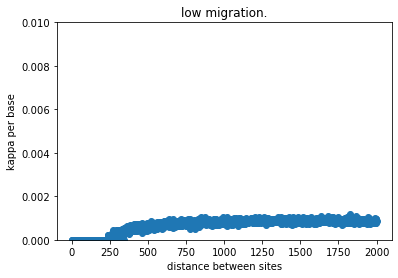

[0.0008010761844636344, 1e-07, 10.0]


In [225]:
test_structure_1 = sim_structured([0,5e-1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

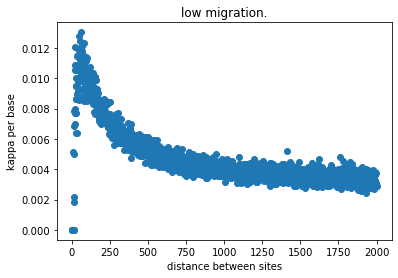

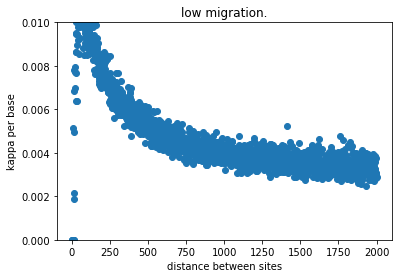

[0.002628235951378284, 0.0049004226591139125, 133.89267212513585]


In [226]:
test_structure_1 = sim_structured([0,5e0])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

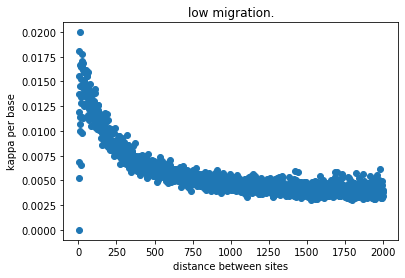

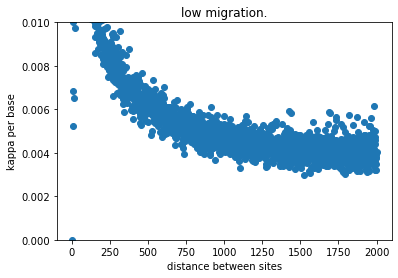

[0.0031419270489749583, 0.006626324858845383, 113.0274133663265]


In [227]:
test_structure_1 = sim_structured([0,5e1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

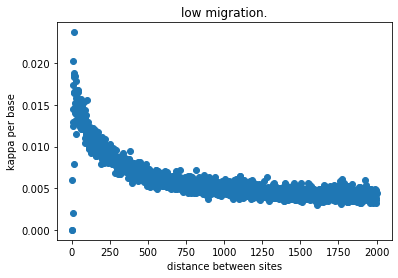

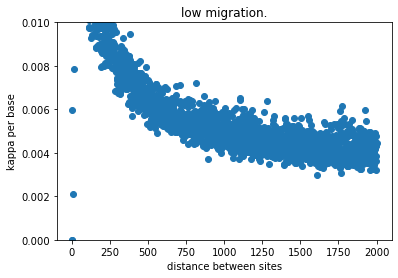

[0.003272494592802089, 0.006353134182837178, 125.5466859078825]


In [228]:
test_structure_1 = sim_structured([0,5e2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

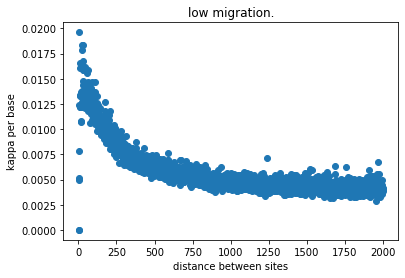

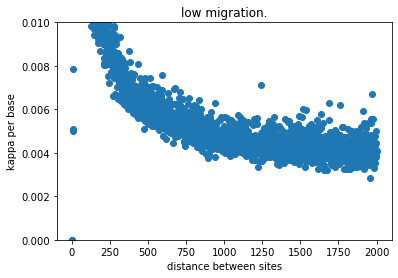

[0.0032638919455976094, 0.006581688862027739, 112.79803620584394]


In [229]:
test_structure_1 = sim_structured([0,5e3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()

plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.ylim(0,0.01)
plt.show()

print(HeRho_estimate_one_chromosome(test_structure_1))

#####  structured pop M = 5e-5 
M in coal time scale units. so per-gen rate is M/(4*Ne), converted in the sim function

In [362]:
test_structure_1 = sim_structured([0,5e-5])
test_structure_1 = np.array(test_structure_1)

In [363]:
print(test_structure_1.tolist())

[[1.0, 19712240.0, 283812.0, 1948.0, 0.007193419341934194], [2.0, 19712257.0, 283778.0, 1965.0, 0.007193419341934193], [3.0, 19712287.0, 283718.0, 1995.0, 0.007193419341934194], [4.0, 19712326.0, 283640.0, 2034.0, 0.007193419341934194], [5.0, 19712271.0, 283751.0, 1978.0, 0.007193394339433943], [6.0, 19712343.0, 283607.0, 2050.0, 0.007193394339433943], [7.0, 19712380.0, 283533.0, 2087.0, 0.007193394339433943], [8.0, 19712213.0, 283867.0, 1920.0, 0.007193394339433943], [9.0, 19712253.0, 283787.0, 1960.0, 0.007193394339433943], [10.0, 19712266.0, 283761.0, 1973.0, 0.007193394339433943], [11.0, 19712236.0, 283821.0, 1943.0, 0.007193394339433943], [12.0, 19712252.0, 283789.0, 1959.0, 0.007193394339433943], [13.0, 19712247.0, 283799.0, 1954.0, 0.007193394339433943], [14.0, 19712290.0, 283713.0, 1997.0, 0.007193394339433943], [15.0, 19712224.0, 283845.0, 1931.0, 0.007193394339433943], [16.0, 19712306.0, 283681.0, 2013.0, 0.007193394339433944], [17.0, 19712266.0, 283761.0, 1973.0, 0.007193394

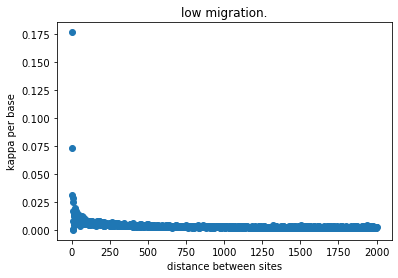

[0.0018089082319082076, 0.003971484966279815, 104.37127051594129]


In [364]:
res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_1))

In [410]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0018089082319082076 / 0.007193444344434444   )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.003971484966279815   / 0.007193444344434444   )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.0502412565722448
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.119969870598839


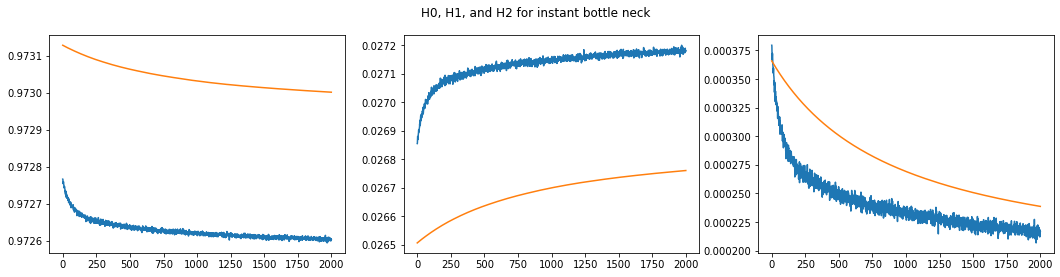

In [358]:
observed_hProbs_structure_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_1[:,[1,2,3]])
expected_hProbs_structure_1 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_1[:,x])
    axs[x].plot(expected_hProbs_structure_1[:,x])
plt.show()

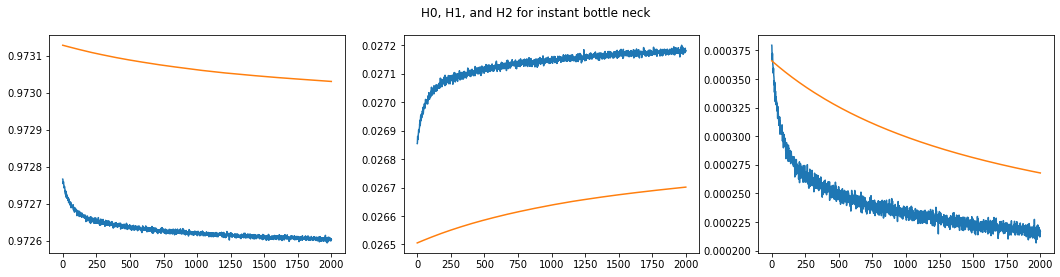

In [359]:

observed_hProbs_structure_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_1[:,[1,2,3]])
expected_hProbs_structure_1 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_1[:,x])
    axs[x].plot(expected_hProbs_structure_1[:,x])
plt.show()

##### structured pop M = 5e-3

In [474]:
test_structure_2 = sim_structured([0,5e-3])
test_structure_2 = np.array(test_structure_2)

In [475]:
print(test_structure_2.tolist())

[[1.0, 49129532.0, 766566.0, 101902.0, 0.009704088163526541], [2.0, 49128917.0, 767796.0, 101287.0, 0.009704088163526541], [3.0, 49128451.0, 768728.0, 100821.0, 0.009704088163526541], [4.0, 49127838.0, 769954.0, 100208.0, 0.009704088163526541], [5.0, 49127181.0, 771268.0, 99551.0, 0.009704088163526541], [6.0, 49126815.0, 772000.0, 99185.0, 0.009704088163526541], [7.0, 49126255.0, 773120.0, 98625.0, 0.009704088163526541], [8.0, 49125775.0, 774080.0, 98145.0, 0.009704088163526541], [9.0, 49125315.0, 775000.0, 97685.0, 0.009704088163526541], [10.0, 49124658.0, 776314.0, 97028.0, 0.009704088163526541], [11.0, 49124327.0, 776976.0, 96697.0, 0.009704088163526541], [12.0, 49123847.0, 777936.0, 96217.0, 0.009704088163526541], [13.0, 49123101.0, 779428.0, 95471.0, 0.009704088163526541], [14.0, 49122987.0, 779656.0, 95357.0, 0.009704088163526541], [15.0, 49122522.0, 780586.0, 94892.0, 0.009704088163526541], [16.0, 49122128.0, 781374.0, 94498.0, 0.009704088163526541], [17.0, 49121852.0, 781926.0,

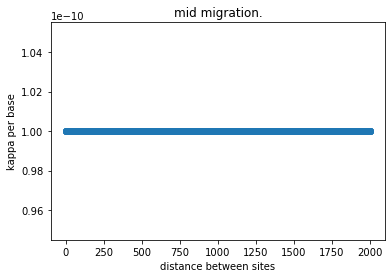

[1e-07, 1e-07, 10.0]


In [476]:
res_structure_2 = [find_max_like_single_dist(x) for x in test_structure_2[:]]
x,y = zip(*res_structure_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("mid migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_2))

In [477]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 1e-7 /   0.010448294829482948 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (   1e-7 /   0.010448294829482948 )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   3.9972748246442565e-05
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.9415334862557814e-05


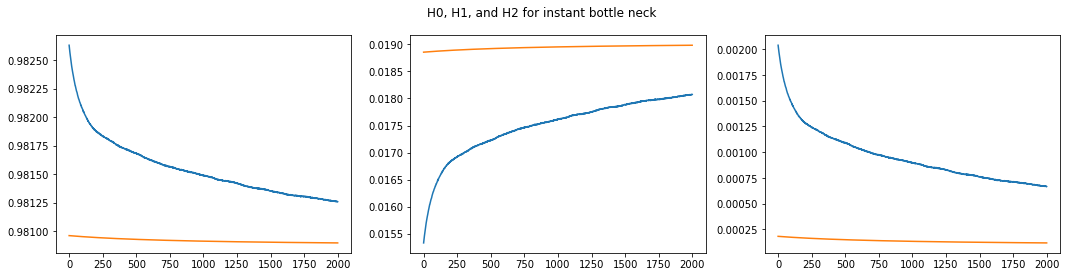

In [478]:
observed_hProbs_structure_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_2[:,[1,2,3]])
expected_hProbs_structure_2 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_2[:,x])
    axs[x].plot(expected_hProbs_structure_2[:,x])
plt.show()

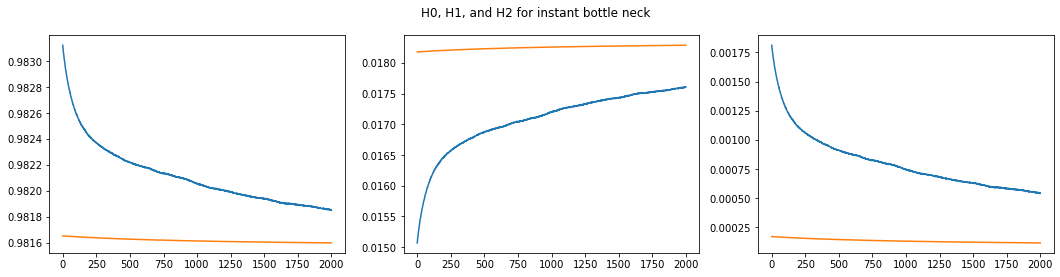

In [448]:
observed_hProbs_structure_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_2[:,[1,2,3]])
expected_hProbs_structure_2 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_2[:,x])
    axs[x].plot(expected_hProbs_structure_2[:,x])
plt.show()

##### structured pop M = 5e-1

In [370]:
test_structure_3 = sim_structured([0,5e-1])
test_structure_3 = np.array(test_structure_3)

In [371]:
print(test_structure_3.tolist())

[[1.0, 19457390.0, 529420.0, 11190.0, 0.013796379637963796], [2.0, 19457414.0, 529372.0, 11214.0, 0.013796379637963797], [3.0, 19457059.0, 530082.0, 10859.0, 0.013796379637963797], [4.0, 19457005.0, 530190.0, 10805.0, 0.013796379637963796], [5.0, 19456955.0, 530290.0, 10755.0, 0.013796379637963797], [6.0, 19456984.0, 530232.0, 10784.0, 0.013796379637963796], [7.0, 19457165.0, 529870.0, 10965.0, 0.013796379637963796], [8.0, 19456888.0, 530424.0, 10688.0, 0.013796379637963796], [9.0, 19456957.0, 530286.0, 10757.0, 0.013796379637963796], [10.0, 19456727.0, 530746.0, 10527.0, 0.013796379637963796], [11.0, 19456600.0, 531000.0, 10400.0, 0.013796379637963797], [12.0, 19456693.0, 530814.0, 10493.0, 0.013796379637963797], [13.0, 19456805.0, 530590.0, 10605.0, 0.013796379637963796], [14.0, 19456683.0, 530834.0, 10483.0, 0.013796379637963797], [15.0, 19456595.0, 531010.0, 10395.0, 0.013796379637963797], [16.0, 19456656.0, 530888.0, 10456.0, 0.013796379637963796], [17.0, 19456596.0, 531008.0, 103

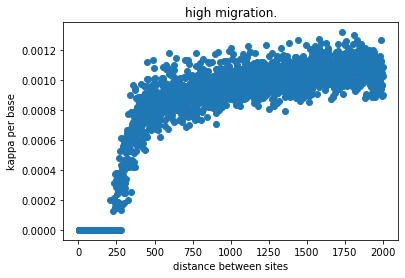

[0.0009574745938185465, 1e-07, 10.0]


In [372]:
res_structure_3 = [find_max_like_single_dist(x) for x in test_structure_3[:]]
x,y = zip(*res_structure_3)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("high migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_3))

In [412]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0009574745938185465 /   0.013796454645464548 )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      (  1e-07  /  0.013796454645464548  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   0.28984725299555725
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   1.4703570451255765e-05


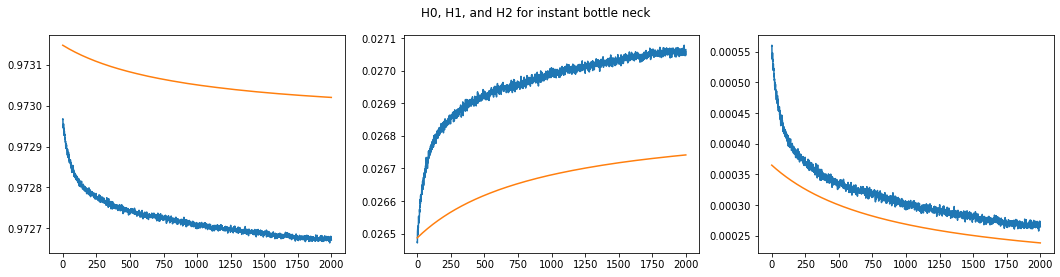

In [373]:
observed_hProbs_structure_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_3[:,[1,2,3]])
expected_hProbs_structure_3 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_3[:,x])
    axs[x].plot(expected_hProbs_structure_3[:,x])
plt.show()

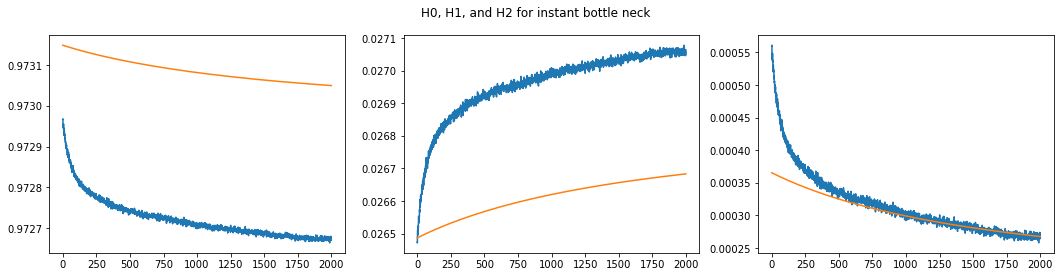

In [374]:
observed_hProbs_structure_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_3[:,[1,2,3]])
expected_hProbs_structure_3 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_3[:,x])
    axs[x].plot(expected_hProbs_structure_3[:,x])
plt.show()

##### structured pop M = 5e1

In [375]:
test_structure_4 = sim_structured([0,5e1])
test_structure_4 = np.array(test_structure_4)

In [376]:
print(test_structure_4.tolist())

[[1.0, 19446730.0, 543586.0, 7684.0, 0.013975247524752474], [2.0, 19446865.0, 543316.0, 7819.0, 0.013975247524752474], [3.0, 19446676.0, 543694.0, 7630.0, 0.013975247524752476], [4.0, 19446557.0, 543931.0, 7512.0, 0.013975272527252725], [5.0, 19446535.0, 543975.0, 7490.0, 0.013975272527252725], [6.0, 19446357.0, 544331.0, 7312.0, 0.013975272527252725], [7.0, 19446484.0, 544077.0, 7439.0, 0.013975272527252725], [8.0, 19446656.0, 543733.0, 7611.0, 0.013975272527252725], [9.0, 19446414.0, 544217.0, 7369.0, 0.013975272527252725], [10.0, 19446408.0, 544229.0, 7363.0, 0.013975272527252726], [11.0, 19446410.0, 544225.0, 7365.0, 0.013975272527252725], [12.0, 19446346.0, 544353.0, 7301.0, 0.013975272527252725], [13.0, 19446362.0, 544321.0, 7317.0, 0.013975272527252725], [14.0, 19446211.0, 544623.0, 7166.0, 0.013975272527252725], [15.0, 19446314.0, 544417.0, 7269.0, 0.013975272527252726], [16.0, 19446143.0, 544758.0, 7099.0, 0.013975297529752975], [17.0, 19446291.0, 544462.0, 7247.0, 0.013975297

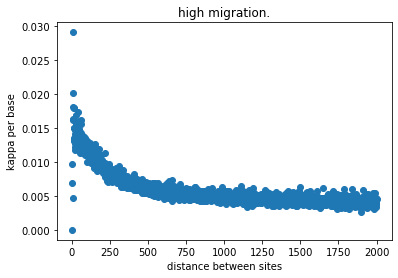

[0.0034429477866067468, 0.006659106163779309, 102.30363598330052]


In [377]:
res_structure_4 = [find_max_like_single_dist(x) for x in test_structure_4[:]]
x,y = zip(*res_structure_4)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("high migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_4))

In [413]:
print("ratio of (rho/theta)_observed / (rho/tehta)_expected:  ",
      ( 0.0034429477866067468 /  0.013975397539753976  )/(0.0017/0.0071))

print("ratio of (gamma/theta)_observed / (gamma/tehta)_expected:  ",
      ( 0.006659106163779309   /  0.013975397539753976  )/(0.0035/0.0071))

ratio of (rho/theta)_observed / (rho/tehta)_expected:   1.0289059847270734
ratio of (gamma/theta)_observed / (gamma/tehta)_expected:   0.9665894988132411


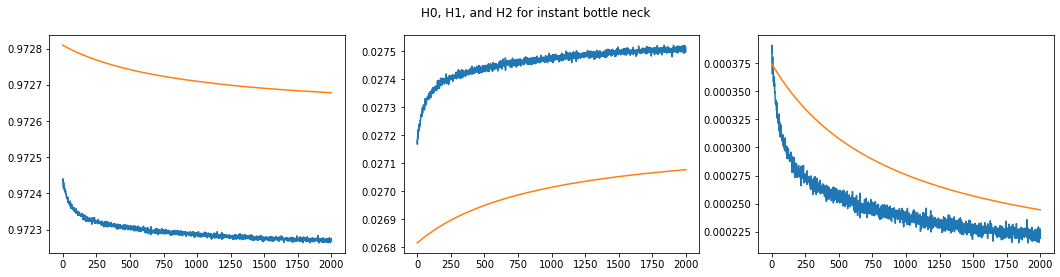

In [378]:
observed_hProbs_structure_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_4[:,[1,2,3]])
expected_hProbs_structure_4 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_4[:,x])
    axs[x].plot(expected_hProbs_structure_4[:,x])
plt.show()

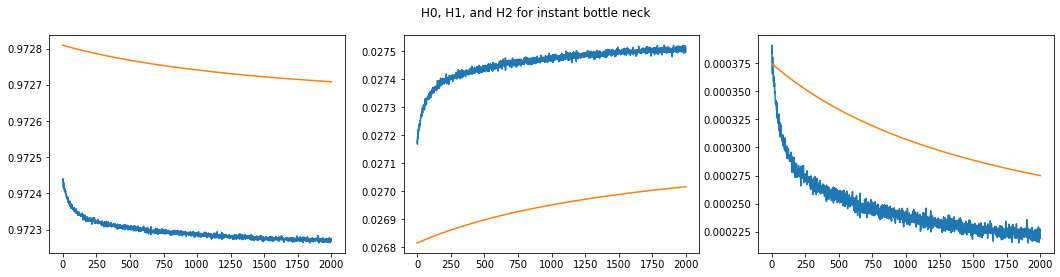

In [379]:
observed_hProbs_structure_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_4[:,[1,2,3]])
expected_hProbs_structure_4 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_4[:,x])
    axs[x].plot(expected_hProbs_structure_4[:,x])
plt.show()

##### structure results combined -- scaled rho/theta -- these are the old results with replicates and converged to good answer

The single-iterations don't have such nice results

Migration rates increase from blue to red to green

In [385]:
scaledRes_structure_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_1,test_structure_1[:,-1],scaled_rho_expected))];
scaledRes_structure_2 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_2,test_structure_2[:,-1],scaled_rho_expected))];
scaledRes_structure_3 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_3,test_structure_3[:,-1],scaled_rho_expected))];
scaledRes_structure_4 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_4,test_structure_4[:,-1],scaled_rho_expected))];
#scaledRes_structure_2 = [ (a,b/c) for ((a,b),c) in list(zip(res_structure_2,test_structure_2[:,-1]))];
#scaledRes_structure_3 = [ (a,b/c) for ((a,b),c) in list(zip(res_structure_3,test_structure_3[:,-1]))];

In [386]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_structure_1[-6:-1]])
print([a[1] for a in scaledRes_structure_2[-6:-1]])
print([a[1] for a in scaledRes_structure_3[-6:-1]])
print([a[1] for a in scaledRes_structure_4[-6:-1]])

true rho/theta = 0.239437
[1.0413869877671766, 0.8328298801096323, 0.895870591196144, 1.0721258888192144, 1.1344398781622738]
[3.268280665955909e-05, 3.268579430813324e-05, 3.26887795085281e-05, 3.26917622637516e-05, 3.269474257680673e-05]
[0.257527650158529, 0.22151145737092287, 0.2551290713999549, 0.25941975117137406, 0.2549198626972601]
[1.1485943733858281, 0.9224176416860299, 1.0890238596190511, 0.9357441101973061, 0.8093650849596834]


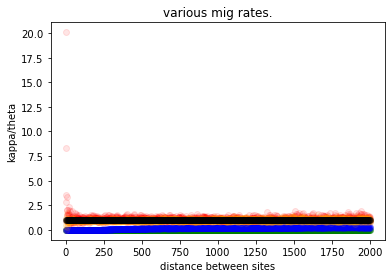

In [387]:
x,y = zip(*scaledRes_structure_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various mig rates.")
plt.show()

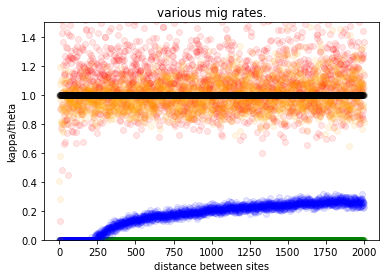

In [388]:
x,y = zip(*scaledRes_structure_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.ylim(0,1.5)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various mig rates.")
plt.show()

# Recombination rate variation

In [549]:
def sim_basic_rec_vary(args):
    itt, rho,gamma,tractLength = args
    
   
    theta = 0.0071
    #rho = 0.0017
    #gamma = 0.0035
    #tractLength = 108
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    gc=gamma/(4*Ne)
    L=20e6
    maxDistance = 2000


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        model=[msprime.StandardCoalescent()],
        ploidy=2,
        population_size=Ne,
        recombination_rate=r,
        gene_conversion_rate=gc,
        gene_conversion_tract_length=tractLength,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)
    

In [529]:
scaled_rho_expected_rec_vary_avg= [[d,get_rho(d, 0.005,0.005,100)/0.0071/d] for d in range(1,2000)]
scaled_rho_expected_rec_vary_avg[0:5]

[[1, 2.1056572184270275],
 [2, 2.098684978397517],
 [3, 2.0917589883329506],
 [4, 2.084878903087212],
 [5, 2.078044380261577]]

### kappa varies
gamma = 0.005
L = 100
kappa = 0.002,  0.005, or 0.008. 

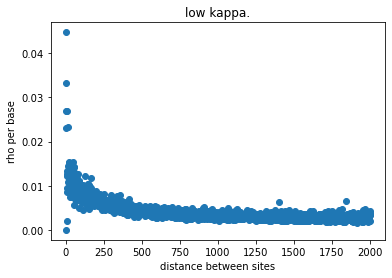

[0.002052694073452728, 0.005242303448535528, 101.93080775243598]


In [550]:
test_low_kappa = sim_basic_rec_vary([0,0.002,0.005,100])
test_low_kappa = np.array(test_low_kappa)

res_low_kappa = [find_max_like_single_dist(x) for x in test_low_kappa[:]]
x,y = zip(*res_low_kappa)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("low kappa.")
plt.show()
print(HeRho_estimate_one_chromosome(test_low_kappa))

In [551]:
print(test_low_kappa.tolist())

[[1.0, 19718073.0, 277952.0, 1975.0, 0.007048254825482548], [2.0, 19718042.0, 278014.0, 1944.0, 0.007048254825482548], [3.0, 19717991.0, 278116.0, 1893.0, 0.007048254825482549], [4.0, 19718006.0, 278086.0, 1908.0, 0.007048254825482548], [5.0, 19717974.0, 278150.0, 1876.0, 0.007048254825482548], [6.0, 19718022.0, 278054.0, 1924.0, 0.007048254825482548], [7.0, 19718030.0, 278038.0, 1932.0, 0.007048254825482548], [8.0, 19718061.0, 277976.0, 1963.0, 0.007048254825482548], [9.0, 19717935.0, 278228.0, 1837.0, 0.007048254825482548], [10.0, 19717998.0, 278102.0, 1900.0, 0.007048254825482548], [11.0, 19717988.0, 278122.0, 1890.0, 0.007048254825482548], [12.0, 19718009.0, 278080.0, 1911.0, 0.007048254825482548], [13.0, 19717963.0, 278172.0, 1865.0, 0.007048254825482548], [14.0, 19717896.0, 278306.0, 1798.0, 0.007048254825482548], [15.0, 19717956.0, 278186.0, 1858.0, 0.007048254825482548], [16.0, 19717954.0, 278190.0, 1856.0, 0.007048254825482548], [17.0, 19717964.0, 278170.0, 1866.0, 0.007048254

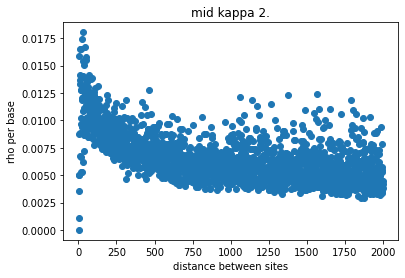

[0.004554940589120598, 0.004081004737686754, 133.46779943608726]


In [552]:
test_mid_kappa_1 = sim_basic_rec_vary([0,0.005,0.005,100])
test_mid_kappa_1 = np.array(test_mid_kappa_1)

res_mid_kappa_1 = [find_max_like_single_dist(x) for x in test_mid_kappa_1[:]]
x,y = zip(*res_mid_kappa_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mid kappa 2.")
plt.show()

print(HeRho_estimate_one_chromosome(test_mid_kappa_1))

In [553]:
print(test_mid_kappa_1.tolist())

[[1.0, 19715804.0, 280164.0, 2032.0, 0.007106410641064107], [2.0, 19715776.0, 280220.0, 2004.0, 0.007106410641064106], [3.0, 19715747.0, 280278.0, 1975.0, 0.007106410641064107], [4.0, 19715755.0, 280262.0, 1983.0, 0.007106410641064106], [5.0, 19715766.0, 280240.0, 1994.0, 0.007106410641064106], [6.0, 19715758.0, 280256.0, 1986.0, 0.007106410641064106], [7.0, 19715755.0, 280262.0, 1983.0, 0.007106410641064106], [8.0, 19715708.0, 280356.0, 1936.0, 0.007106410641064107], [9.0, 19715739.0, 280294.0, 1967.0, 0.007106410641064107], [10.0, 19715695.0, 280382.0, 1923.0, 0.007106410641064107], [11.0, 19715717.0, 280338.0, 1945.0, 0.007106410641064106], [12.0, 19715662.0, 280448.0, 1890.0, 0.007106410641064106], [13.0, 19715675.0, 280422.0, 1903.0, 0.007106410641064106], [14.0, 19715672.0, 280428.0, 1900.0, 0.007106410641064106], [15.0, 19715686.0, 280400.0, 1914.0, 0.007106410641064107], [16.0, 19715712.0, 280348.0, 1940.0, 0.007106410641064107], [17.0, 19715680.0, 280412.0, 1908.0, 0.007106410

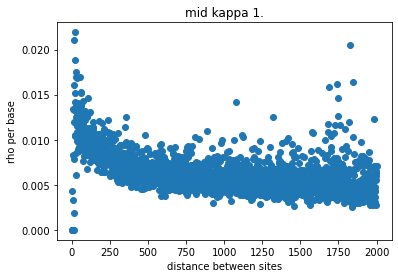

[0.004471577839572575, 0.004300486653359343, 115.75576496851376]


In [554]:
test_mid_kappa_2 = sim_basic_rec_vary([0,0.005,0.005,100])
test_mid_kappa_2 = np.array(test_mid_kappa_2)

res_mid_kappa_2 = [find_max_like_single_dist(x) for x in test_mid_kappa_2[:]]
x,y = zip(*res_mid_kappa_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mid kappa 1.")
plt.show()

print(HeRho_estimate_one_chromosome(test_mid_kappa_2))

In [555]:
print(test_mid_kappa_2.tolist())

[[1.0, 19720273.0, 275788.0, 1939.0, 0.006992349234923492], [2.0, 19720320.0, 275694.0, 1986.0, 0.006992349234923492], [3.0, 19720293.0, 275748.0, 1959.0, 0.006992349234923492], [4.0, 19720255.0, 275824.0, 1921.0, 0.006992349234923492], [5.0, 19720235.0, 275864.0, 1901.0, 0.006992349234923493], [6.0, 19720302.0, 275730.0, 1968.0, 0.006992349234923492], [7.0, 19720296.0, 275742.0, 1962.0, 0.006992349234923492], [8.0, 19720313.0, 275708.0, 1979.0, 0.006992349234923493], [9.0, 19720257.0, 275820.0, 1923.0, 0.006992349234923492], [10.0, 19720198.0, 275938.0, 1864.0, 0.006992349234923492], [11.0, 19720263.0, 275808.0, 1929.0, 0.006992349234923492], [12.0, 19720285.0, 275764.0, 1951.0, 0.006992349234923492], [13.0, 19720186.0, 275962.0, 1852.0, 0.006992349234923492], [14.0, 19720118.0, 276098.0, 1784.0, 0.006992349234923492], [15.0, 19720143.0, 276048.0, 1809.0, 0.006992349234923492], [16.0, 19720202.0, 275930.0, 1868.0, 0.006992349234923492], [17.0, 19720143.0, 276048.0, 1809.0, 0.006992349

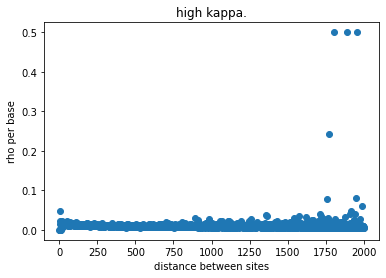

[0.007847266285100362, 0.004093050221826277, 116.73141595202001]


In [556]:
test_high_kappa = sim_basic_rec_vary([0,0.008,0.005,100])
test_high_kappa = np.array(test_high_kappa)

res_high_kappa = [find_max_like_single_dist(x) for x in test_high_kappa[:]]
x,y = zip(*res_high_kappa)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("high kappa.")
plt.show()
print(HeRho_estimate_one_chromosome(test_high_kappa))

In [557]:
print(test_high_kappa.tolist())

[[1.0, 19720716.0, 275342.0, 1942.0, 0.006981348134813481], [2.0, 19720727.0, 275320.0, 1953.0, 0.006981348134813482], [3.0, 19720754.0, 275266.0, 1980.0, 0.006981348134813482], [4.0, 19720604.0, 275566.0, 1830.0, 0.006981348134813481], [5.0, 19720666.0, 275442.0, 1892.0, 0.006981348134813482], [6.0, 19720704.0, 275366.0, 1930.0, 0.006981348134813482], [7.0, 19720615.0, 275544.0, 1841.0, 0.006981348134813482], [8.0, 19720723.0, 275328.0, 1949.0, 0.006981348134813482], [9.0, 19720738.0, 275298.0, 1964.0, 0.006981348134813482], [10.0, 19720666.0, 275442.0, 1892.0, 0.006981348134813482], [11.0, 19720647.0, 275480.0, 1873.0, 0.006981348134813482], [12.0, 19720617.0, 275540.0, 1843.0, 0.006981348134813481], [13.0, 19720672.0, 275430.0, 1898.0, 0.006981348134813481], [14.0, 19720591.0, 275592.0, 1817.0, 0.006981348134813481], [15.0, 19720656.0, 275462.0, 1882.0, 0.006981348134813481], [16.0, 19720603.0, 275568.0, 1829.0, 0.006981348134813482], [17.0, 19720573.0, 275628.0, 1799.0, 0.006981348

In [558]:
mixed_kappa_low_high = combine_rep_results([test_low_kappa,test_high_kappa])
mixed_kappa_mid_mid = combine_rep_results([test_mid_kappa_1,test_mid_kappa_2])

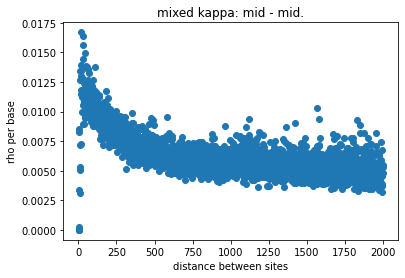

[0.004512656427091102, 0.004184279197642186, 124.3258323056699]


In [559]:
res_mixed_kappa_mid_mid = [find_max_like_single_dist(x) for x in mixed_kappa_mid_mid[:]]
x,y = zip(*res_mixed_kappa_mid_mid)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mixed kappa: mid - mid.")
plt.show()
print(HeRho_estimate_one_chromosome(mixed_kappa_mid_mid))

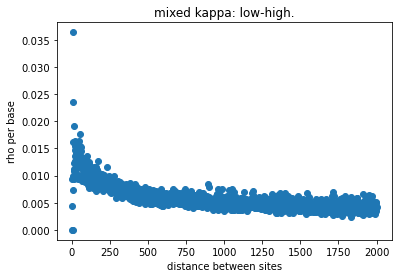

[0.0033715490671447843, 0.00518895923238538, 138.00356122872944]


In [560]:
res_mixed_kappa_low_high= [find_max_like_single_dist(x) for x in mixed_kappa_low_high[:]]
x,y = zip(*res_mixed_kappa_low_high)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mixed kappa: low-high.")
plt.show()
print(HeRho_estimate_one_chromosome(mixed_kappa_low_high))

In [561]:
scaledRes_mixed_kappa_low_high = [ (a,b/c) for ((a,b),c) in list(zip(res_mixed_kappa_low_high,mixed_kappa_low_high[:,-1]))];
scaledRes_mixed_kappa_mid_mid = [ (a,b/c) for ((a,b),c) in list(zip(res_mixed_kappa_mid_mid,mixed_kappa_mid_mid[:,-1]))];

In [562]:
scaledRes_mixed_kappa_low_high = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_kappa_low_high,mixed_kappa_low_high[:,-1],scaled_rho_expected_rec_vary_avg))];
scaledRes_mixed_kappa_mid_mid = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_kappa_mid_mid,mixed_kappa_mid_mid[:,-1],scaled_rho_expected_rec_vary_avg))];

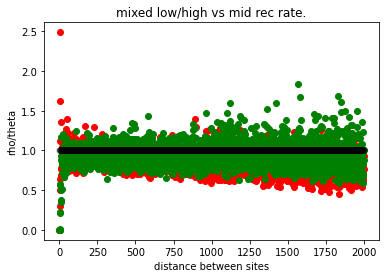

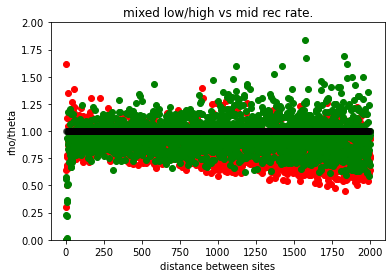

In [563]:
x,y = zip(*scaledRes_mixed_kappa_low_high)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_mixed_kappa_mid_mid)
plt.scatter(x,y,color='green')

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.xlabel("distance between sites")
plt.ylabel("rho/theta")
plt.title("mixed low/high vs mid rec rate.")
plt.show()

x,y = zip(*scaledRes_mixed_kappa_low_high)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_mixed_kappa_mid_mid)
plt.scatter(x,y,color='green')

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.ylim(0,2)
plt.xlabel("distance between sites")
plt.ylabel("rho/theta")
plt.title("mixed low/high vs mid rec rate.")
plt.show()

### gamma varies
gamma = 0.002, 0.005, or 0.008
L = 100
kappa =0.005 

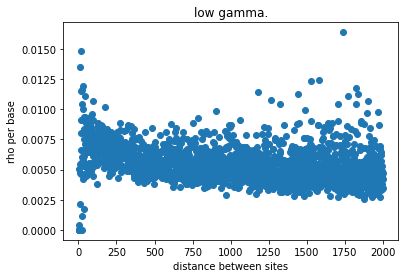

[0.0044894993654045826, 0.001705325827174084, 167.57649448272028]


In [564]:
test_low_gamma = sim_basic_rec_vary([0,0.005,0.002,100])
test_low_gamma = np.array(test_low_gamma)

res_low_gamma = [find_max_like_single_dist(x) for x in test_low_gamma[:]]
x,y = zip(*res_low_gamma)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("low gamma.")
plt.show()
print(HeRho_estimate_one_chromosome(test_low_gamma))

In [565]:
print(test_low_gamma.tolist())

[[1.0, 19720493.0, 275560.0, 1947.0, 0.006987048704870487], [2.0, 19720516.0, 275514.0, 1970.0, 0.006987048704870487], [3.0, 19720522.0, 275502.0, 1976.0, 0.006987048704870487], [4.0, 19720507.0, 275532.0, 1961.0, 0.0069870487048704875], [5.0, 19720499.0, 275548.0, 1953.0, 0.0069870487048704875], [6.0, 19720466.0, 275614.0, 1920.0, 0.0069870487048704875], [7.0, 19720483.0, 275580.0, 1937.0, 0.006987048704870487], [8.0, 19720474.0, 275598.0, 1928.0, 0.006987048704870487], [9.0, 19720505.0, 275536.0, 1959.0, 0.0069870487048704875], [10.0, 19720456.0, 275634.0, 1910.0, 0.006987048704870487], [11.0, 19720399.0, 275748.0, 1853.0, 0.006987048704870487], [12.0, 19720488.0, 275570.0, 1942.0, 0.006987048704870487], [13.0, 19720442.0, 275662.0, 1896.0, 0.0069870487048704875], [14.0, 19720445.0, 275656.0, 1899.0, 0.0069870487048704875], [15.0, 19720361.0, 275824.0, 1815.0, 0.0069870487048704875], [16.0, 19720400.0, 275746.0, 1854.0, 0.0069870487048704875], [17.0, 19720418.0, 275710.0, 1872.0, 0.0

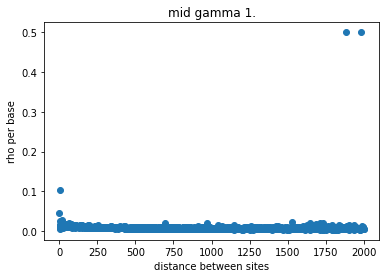

[0.005495310211888415, 0.005843752278982399, 82.98069734485048]


In [566]:
test_mid_gamma_1 = sim_basic_rec_vary([0,0.005,0.005,100])
test_mid_gamma_1 = np.array(test_mid_gamma_1)

res_mid_gamma_1 = [find_max_like_single_dist(x) for x in test_mid_gamma_1[:]]
x,y = zip(*res_mid_gamma_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mid gamma 1.")
plt.show()

print(HeRho_estimate_one_chromosome(test_mid_gamma_1))

In [567]:
print(test_mid_gamma_1.tolist())

[[1.0, 19715107.0, 280908.0, 1985.0, 0.0071226622662266224], [2.0, 19715017.0, 281088.0, 1895.0, 0.0071226622662266224], [3.0, 19715127.0, 280868.0, 2005.0, 0.0071226622662266224], [4.0, 19715096.0, 280930.0, 1974.0, 0.007122662266226623], [5.0, 19715060.0, 281002.0, 1938.0, 0.0071226622662266224], [6.0, 19715086.0, 280950.0, 1964.0, 0.007122662266226623], [7.0, 19715072.0, 280978.0, 1950.0, 0.0071226622662266224], [8.0, 19715104.0, 280914.0, 1982.0, 0.007122662266226623], [9.0, 19715031.0, 281060.0, 1909.0, 0.007122662266226623], [10.0, 19715017.0, 281088.0, 1895.0, 0.0071226622662266224], [11.0, 19715048.0, 281026.0, 1926.0, 0.0071226622662266224], [12.0, 19714983.0, 281156.0, 1861.0, 0.0071226622662266224], [13.0, 19715036.0, 281050.0, 1914.0, 0.007122662266226623], [14.0, 19715035.0, 281052.0, 1913.0, 0.0071226622662266224], [15.0, 19714964.0, 281194.0, 1842.0, 0.0071226622662266224], [16.0, 19714916.0, 281290.0, 1794.0, 0.007122662266226623], [17.0, 19714941.0, 281240.0, 1819.0, 0

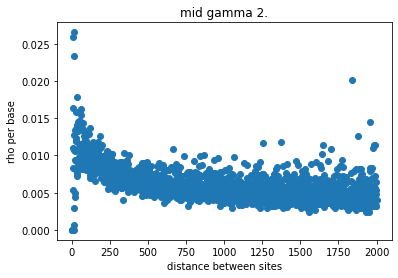

[0.003937456895617237, 0.004059500343228564, 153.86526994561808]


In [568]:
test_mid_gamma_2 = sim_basic_rec_vary([0,0.005,0.005,100])
test_mid_gamma_2 = np.array(test_mid_gamma_2)

res_mid_gamma_2 = [find_max_like_single_dist(x) for x in test_mid_gamma_2[:]]
x,y = zip(*res_mid_gamma_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mid gamma 2.")
plt.show()

print(HeRho_estimate_one_chromosome(test_mid_gamma_2))

In [569]:
print(test_mid_gamma_2.tolist())

[[1.0, 19723161.0, 272878.0, 1961.0, 0.006920692069206921], [2.0, 19723150.0, 272900.0, 1950.0, 0.0069206920692069206], [3.0, 19723118.0, 272964.0, 1918.0, 0.0069206920692069206], [4.0, 19723089.0, 273022.0, 1889.0, 0.0069206920692069206], [5.0, 19723077.0, 273046.0, 1877.0, 0.0069206920692069206], [6.0, 19723126.0, 272948.0, 1926.0, 0.0069206920692069206], [7.0, 19723036.0, 273128.0, 1836.0, 0.006920692069206921], [8.0, 19722988.0, 273224.0, 1788.0, 0.0069206920692069206], [9.0, 19723044.0, 273112.0, 1844.0, 0.0069206920692069206], [10.0, 19723040.0, 273120.0, 1840.0, 0.0069206920692069206], [11.0, 19723155.0, 272890.0, 1955.0, 0.0069206920692069206], [12.0, 19722954.0, 273292.0, 1754.0, 0.0069206920692069206], [13.0, 19723079.0, 273042.0, 1879.0, 0.0069206920692069206], [14.0, 19722915.0, 273370.0, 1715.0, 0.0069206920692069206], [15.0, 19723096.0, 273008.0, 1896.0, 0.0069206920692069206], [16.0, 19722990.0, 273220.0, 1790.0, 0.0069206920692069206], [17.0, 19723052.0, 273096.0, 1852.

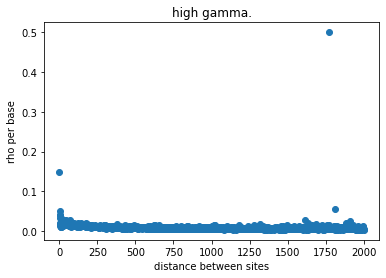

[0.004891936398099903, 0.008040676683361284, 106.70284151616775]


In [570]:
test_high_gamma = sim_basic_rec_vary([0,0.005,0.008,100])
test_high_gamma = np.array(test_high_gamma)

res_high_gamma = [find_max_like_single_dist(x) for x in test_high_gamma[:]]
x,y = zip(*res_high_gamma)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("high gamma.")
plt.show()
print(HeRho_estimate_one_chromosome(test_high_gamma))

In [571]:
print(test_high_gamma.tolist())

[[1.0, 19714625.0, 281444.0, 1931.0, 0.007133363336333633], [2.0, 19714691.0, 281312.0, 1997.0, 0.007133363336333633], [3.0, 19714622.0, 281450.0, 1928.0, 0.007133363336333633], [4.0, 19714634.0, 281426.0, 1940.0, 0.007133363336333634], [5.0, 19714674.0, 281346.0, 1980.0, 0.007133363336333633], [6.0, 19714573.0, 281548.0, 1879.0, 0.007133363336333633], [7.0, 19714632.0, 281430.0, 1938.0, 0.007133363336333634], [8.0, 19714534.0, 281626.0, 1840.0, 0.007133363336333633], [9.0, 19714664.0, 281366.0, 1970.0, 0.007133363336333633], [10.0, 19714591.0, 281512.0, 1897.0, 0.007133363336333633], [11.0, 19714518.0, 281658.0, 1824.0, 0.007133363336333633], [12.0, 19714633.0, 281428.0, 1939.0, 0.007133363336333633], [13.0, 19714630.0, 281434.0, 1936.0, 0.007133363336333633], [14.0, 19714537.0, 281620.0, 1843.0, 0.007133363336333633], [15.0, 19714491.0, 281712.0, 1797.0, 0.007133363336333634], [16.0, 19714528.0, 281638.0, 1834.0, 0.007133363336333634], [17.0, 19714527.0, 281640.0, 1833.0, 0.007133363

In [572]:
mixed_gamma_low_high = combine_rep_results([test_low_gamma,test_high_gamma])
mixed_gamma_mid_mid = combine_rep_results([test_mid_gamma_1,test_mid_gamma_2])

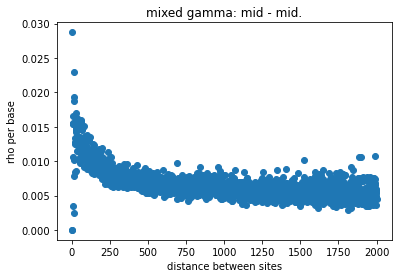

[0.0046738866856624525, 0.004824900418360362, 113.5707179605997]


In [573]:
res_mixed_gamma_mid_mid = [find_max_like_single_dist(x) for x in mixed_gamma_mid_mid[:]]
x,y = zip(*res_mixed_gamma_mid_mid)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mixed gamma: mid - mid.")
plt.show()
print(HeRho_estimate_one_chromosome(mixed_gamma_mid_mid))

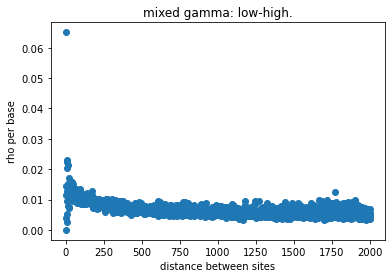

[0.004720625447879382, 0.004372700576788333, 118.32324231903726]


In [574]:
res_mixed_gamma_low_high= [find_max_like_single_dist(x) for x in mixed_gamma_low_high[:]]
x,y = zip(*res_mixed_gamma_low_high)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("rho per base")
plt.title("mixed gamma: low-high.")
plt.show()
print(HeRho_estimate_one_chromosome(mixed_gamma_low_high))

In [575]:
scaledRes_mixed_gamma_low_high = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_gamma_low_high,mixed_gamma_low_high[:,-1],scaled_rho_expected_rec_vary_avg))];
scaledRes_mixed_gamma_mid_mid = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_gamma_mid_mid,mixed_gamma_mid_mid[:,-1],scaled_rho_expected_rec_vary_avg))];

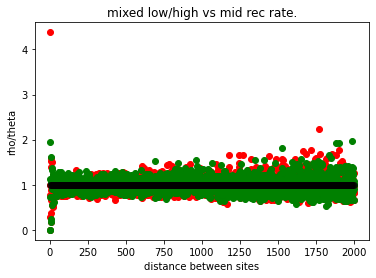

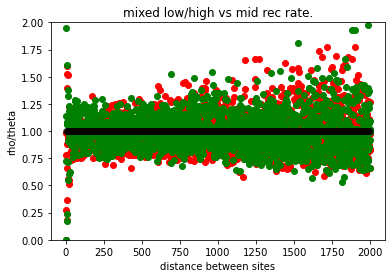

In [576]:
x,y = zip(*scaledRes_mixed_gamma_low_high)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_mixed_gamma_mid_mid)
plt.scatter(x,y,color='green')

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.xlabel("distance between sites")
plt.ylabel("rho/theta")
plt.title("mixed low/high vs mid rec rate.")
plt.show()

x,y = zip(*scaledRes_mixed_gamma_low_high)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_mixed_gamma_mid_mid)
plt.scatter(x,y,color='green')

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.ylim(0,2)
plt.xlabel("distance between sites")
plt.ylabel("rho/theta")
plt.title("mixed low/high vs mid rec rate.")
plt.show()